# Recombination & Retrival for Servoing

This notebook shows an example of how a suitable demonstration can be selected if several candidates are avaliable. The current selection is based on reprojection error.

Instructions:

    1. Record and Segment Demonstrations using `Record_and_Segment.ipynb`


## 1. Load Existing Demonstrations

In [1]:
import os
import copy
import json
import logging
from glob import glob
from pathlib import Path

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import widgets, interact, Layout

from flow_control.demo.playback_env_servo import PlaybackEnvServo

root_dir = "/tmp/flow_experiments3"
task = "shape_sorting"
object_selected = "trapeze" 
task_variant = "rP"  # rotation plus (+-pi)

def get_configurations(root_dir=root_dir, num_episodes=40, prefix=""):
    os.makedirs(root_dir, exist_ok=True)
    save_dir_template = os.path.join(root_dir, f"{prefix}_{task}_{object_selected}")
    for seed in range(num_episodes):
        save_dir = save_dir_template + f"_{task_variant}"+f"_seed{seed:03d}"
        yield object_selected, seed, save_dir
            
demo_cfgs = get_configurations(prefix="demo")
recordings = []
for _, demo_seed, demo_dir in demo_cfgs:
    recordings.append(demo_dir)
    
print("Number of recordings:", len(recordings))
print("first", recordings[0])
print("last ", recordings[-1])

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Number of recordings: 40
first /tmp/flow_experiments3/demo_shape_sorting_trapeze_rP_seed000
last  /tmp/flow_experiments3/demo_shape_sorting_trapeze_rP_seed039


In [2]:
# Load the demonstration episodes
playbacks = [PlaybackEnvServo(rec) for rec in recordings[:]]

# If you get Warnings: Couldn't find servoing keyframes, you need to segment the demos
# This is shown in Record_and_Segment.ipynb 

<IPython.core.display.Javascript object>


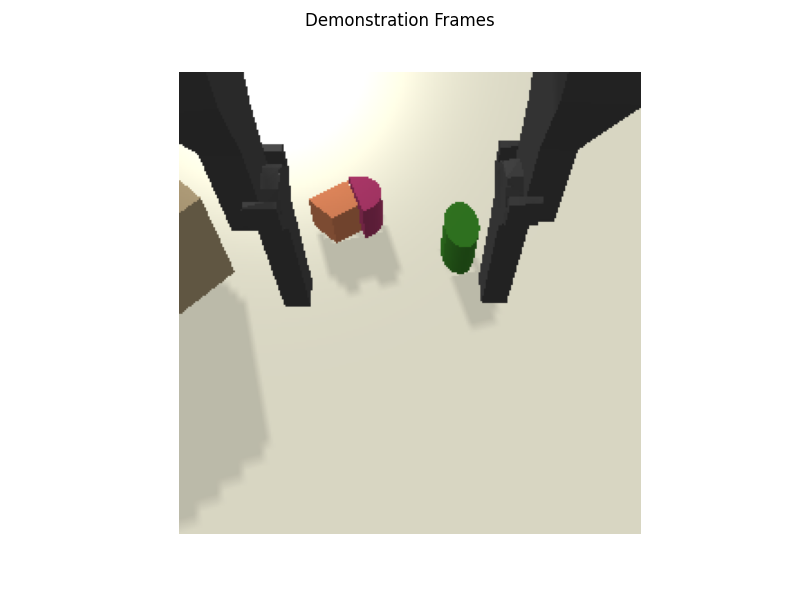

interactive(children=(IntSlider(value=0, description='demo_index', layout=Layout(width='70%'), max=39), IntSli…

<function __main__.update(demo_index, frame_index)>

In [3]:
# Plot the demonstrations
%matplotlib notebook
fig, ax = plt.subplots(1,figsize=(8, 6))
fig.suptitle("Demonstration Frames")
ax.set_axis_off()
image_h = ax.imshow(playbacks[0].cam.get_image()[0])

def update(demo_index, frame_index):
    image = playbacks[demo_index][frame_index].cam.get_image()[0]
    image_h.set_data(image)
    fig.canvas.draw_idle()
    print("wp_name:", playbacks[demo_index][frame_index].get_info()["wp_name"])
    print("keep:", playbacks[demo_index].keep_dict.keys())
    fg_mask = playbacks[demo_index].get_fg_mask()
    if fg_mask is not None:
        print(f"percent fg @ {demo_index}, 0:", round(np.mean(fg_mask)*100,2))
    
slider_w = widgets.IntSlider(min=0, max=len(playbacks)-1, step=1, value=0,
                             layout=Layout(width='70%'))
slider_i = widgets.IntSlider(min=0, max=200-1, step=1, value=0,
                             layout=Layout(width='70%'))

interact(update, demo_index=slider_w, frame_index=slider_i)

# Filter Bad Demonstrations

In [4]:
# Summarize the demonstration info
def filter_demo(pb):
    return pb[-1].data['rew'] > 0 and np.mean(pb.get_fg_mask()) > 0.005

demo_good = [filter_demo(pb) for pb in playbacks]

# print summary
fg_pixels = [np.mean(pb.get_fg_mask())*100 for pb in playbacks]
header = "ep\t len\t rew\t fg[%] bad"
print(header,"\n"+"-"*len(header.replace("\t"," "*5)))
for i, pb in enumerate(playbacks):
    print(i, "\t", len(pb), "\t", pb[-1].data["rew"],"\t", round(fg_pixels[i], 2),"\tx" if not demo_good[i] else '')    
print()

bad_pair_arr = np.zeros((len(playbacks), len(playbacks)), dtype=bool)
for idx in np.where(np.array(demo_good) == False)[0]:
    bad_pair_arr[:,idx] = True
    bad_pair_arr[idx,:] = True
bad_pair_arr += np.eye(len(playbacks), len(playbacks), dtype=bool)
#print(bad_pairs.astype(int))
good_pairs = list(zip(*np.where(bad_pair_arr==False)))

print(f"Good demos:   {np.mean(demo_good)*100:.1f} %\t", sum(demo_good),"/",len(demo_good) )
print(f"Viable pairs: {(1-bad_pair_arr.mean())*100:.1f} %\t",sum(bad_pair_arr.flatten()==0),"/", bad_pair_arr.size)



ep	 len	 rew	 fg[%] bad 
-----------------------------------
0 	 48 	 1.0 	 1.02 
1 	 200 	 0.0 	 1.12 	x
2 	 48 	 1.0 	 0.43 	x
3 	 46 	 1.0 	 1.12 
4 	 48 	 1.0 	 1.08 
5 	 49 	 1.0 	 0.71 
6 	 46 	 1.0 	 1.05 
7 	 46 	 1.0 	 0.58 
8 	 47 	 1.0 	 1.09 
9 	 46 	 1.0 	 0.77 
10 	 46 	 1.0 	 1.17 
11 	 46 	 1.0 	 1.19 
12 	 48 	 1.0 	 1.02 
13 	 47 	 1.0 	 0.92 
14 	 48 	 1.0 	 1.13 
15 	 48 	 1.0 	 1.1 
16 	 49 	 1.0 	 1.22 
17 	 49 	 1.0 	 1.12 
18 	 48 	 1.0 	 1.0 
19 	 49 	 1.0 	 1.15 
20 	 47 	 1.0 	 1.09 
21 	 47 	 1.0 	 1.07 
22 	 47 	 1.0 	 1.21 
23 	 47 	 1.0 	 0.91 
24 	 46 	 1.0 	 1.26 
25 	 46 	 1.0 	 0.6 
26 	 200 	 0.0 	 1.11 	x
27 	 46 	 1.0 	 1.37 
28 	 47 	 1.0 	 1.15 
29 	 48 	 1.0 	 1.05 
30 	 200 	 0.0 	 0.84 	x
31 	 47 	 1.0 	 1.31 
32 	 48 	 1.0 	 1.05 
33 	 47 	 1.0 	 1.1 
34 	 53 	 1.0 	 1.25 
35 	 49 	 1.0 	 1.19 
36 	 46 	 1.0 	 1.15 
37 	 48 	 1.0 	 1.2 
38 	 48 	 1.0 	 1.06 
39 	 48 	 1.0 	 1.09 

Good demos:   90.0 %	 36 / 40
Viable pairs: 78.8 %	 1260 / 160

## Compute Similarity for Viable Pairs

Given the set of viable pairs, compute how similar the inital frames are.

In [21]:
from r3m import load_r3m
import torchvision.transforms as T
import torch
import ipdb

transform = T.Compose([T.ToTensor()])

def get_r3m_embeddings(playbacks, transform=None, device='cuda', masked=False):
    embeddings = []

    r3m = load_r3m("resnet50")
    r3m.eval()
    r3m.to(device)
    
    with torch.no_grad():
        
        for pb in playbacks:
            im = pb[0].cam.get_image()[0]
            
            if masked:
                mask = pb.get_fg_mask()
                mask = mask[..., np.newaxis].repeat(3, axis=2)
                im = im * mask
                
            im = transform(im)

            im = im.unsqueeze(0).to(device)
            embeddings.append(r3m(im * 255.0))
        
        embeddings = torch.cat(embeddings)
    
    embeddings = embeddings.detach().cpu().numpy()
    
    return embeddings

embeddings_with_mask = get_r3m_embeddings(playbacks, transform=transform, device='cuda', masked=True)
embeddings_without_mask = get_r3m_embeddings(playbacks, transform=transform, device='cuda', masked=False)

/home/argusm/miniconda3/envs/ur_env/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [22]:
sim_scores = np.ones(bad_pair_arr.shape) * 10.0  # lower is better

for live_i, demo_i in tqdm(good_pairs):
    live_embedding = embeddings_without_mask[live_i, :] 
    
    demo_embedding = embeddings_with_mask[demo_i, :]
    error = np.linalg.norm(live_embedding - demo_embedding)
    print(error)
#     assert error <= 1.0
    sim_scores[demo_i, live_i] = error

100%|████████████████████████████████████████████████████████████████████████████████████| 1260/1260 [00:00<00:00, 84347.99it/s]

4.103513
4.088006
4.145925
4.1491494
4.209689
4.085101
4.126917
4.0694647
4.083671
4.110675
4.1102896
4.1099195
4.103739
4.1226115
4.1209946
4.09775
4.1073694
4.094441
4.0969777
4.126071
4.111307
4.0849466
4.1664977
4.092333
4.124615
4.0972424
4.1163588
4.0733576
4.082719
4.0678945
4.0696325
4.0777884
4.1206665
4.110889
4.079426
4.2495575
4.25284
4.312467
4.3022213
4.367427
4.2492013
4.2919135
4.235325
4.2465544
4.274936
4.2743897
4.272702
4.268554
4.285901
4.2827888
4.2629695
4.268483
4.256693
4.2597685
4.283764
4.2734947
4.248727
4.329211
4.2502074
4.285271
4.2617745
4.273353
4.236416
4.2496624
4.2310214
4.2339544
4.23998
4.2816978
4.2772126
4.2430844
4.2354074
4.2558007
4.2984324
4.284349
4.349294
4.2340984
4.276922
4.2194963
4.2326884
4.2605133
4.261146
4.2564373
4.2540216
4.2681155
4.266761
4.24848
4.2514925
4.243725
4.2459726
4.2669826
4.2597184
4.2321477
4.315544
4.2329235
4.269634
4.2475576
4.256146
4.222439
4.2343726
4.21552
4.2198677
4.226189
4.2642055
4.2622995
4.228578
4.21

## 2. Pick Best Demonstrations

Given a list of all possible pairs, find the best demonstrations.
Also plot demonstrations by order of goodness.

In [23]:
good_episode = np.any(demo_good, axis=0)
print("live episode", np.arange(len(recordings))[good_episode])
print("demo episode", np.argmin(sim_scores, axis=0)[good_episode])

live episode [[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]]
demo episode [[34  0  0 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34
  34 34  0 34 34 34  0 34 10 34 10 34 34 34 34 34]]


In [28]:
fig, (ax, ax2) = plt.subplots(1, 2)
fig.suptitle("Ranked Similarity Scores")
ax.set_title("live")
ax2.set_title("demo")
ax.set_axis_off()
ax2.set_axis_off()
empty_image = np.zeros((256, 256), dtype=np.uint8)
image_h = ax.imshow(empty_image)
image_h2 = ax2.imshow(empty_image)

def update(live_index, demo_rank):
    image_l = playbacks[live_index][0].cam.get_image()[0]
    image_h.set_data(image_l)
    # chose d'th best demo
    demo_i = np.argsort(sim_scores[:, live_index])[demo_rank]
    ax.set_title(f"live @ {live_index}, 0")
    ax2.set_title(f"rank {demo_rank} demo @ {demo_i}, 0")
    
    if not (demo_i, live_index) in good_pairs:
        image_h2.set_data(empty_image)
        print("no good demo.")
        return
    print(f"{demo_rank} th best demo is {demo_i}   r3m. err {sim_scores[demo_i, live_index]:.2f}")
    image_d = playbacks[demo_i][0].cam.get_image()[0]
    image_h2.set_data(image_d)
    fig.canvas.draw_idle()
    
slider_l = widgets.IntSlider(min=0, max=len(recordings)-1, step=1, value=3,
                             layout=Layout(width='70%'))
slider_d = widgets.IntSlider(min=0, max=len(recordings)-1, step=1, value=0,
                             layout=Layout(width='70%'))
interact(update, live_index=slider_l, demo_rank=slider_d)
plt.tight_layout()
plt.show()

interactive(children=(IntSlider(value=3, description='live_index', layout=Layout(width='70%'), max=39), IntSli…

## Run Servoing

For a live run, we know what the best demonstration is, evaluate this.

In [18]:
import shutil
from math import pi
from gym_grasping.envs.robot_sim_env import RobotSimEnv
from flow_control.servoing.module import ServoingModule
from flow_control.servoing.runner import evaluate_control

renderer = "debug"
control_config = dict(mode="pointcloud-abs-rotz", threshold=0.35)

def get_save_dir(root_dir, live_seed, demo_seed):
    prefix = "run"
    save_dir_template = os.path.join(root_dir, f"{prefix}_{task}_{object_selected}")
    save_dir = save_dir_template + f"_{task_variant}_seed{live_seed:03d}_demo{demo_seed:03d}" 
    return save_dir    

def eval_cmb(live_seed, demo_seed, exist_ok=False):
    save_dir = get_save_dir(root_dir, live_seed, demo_seed)
    if Path(save_dir).is_dir():
        if exist_ok:
            shutil.rmtree(save_dir)
        else:
            raise ValueError
    print("saving to:", save_dir)
    demo_dir = recordings[demo_seed]
    servo_module = ServoingModule(demo_dir, control_config=control_config,
                                  start_paused=False, plot=False, plot_save_dir=None, flow_module="RAFT")
    
    env = RobotSimEnv(task='shape_sorting', renderer=renderer, act_type='continuous',
                      initial_pose='close', max_steps=500, control='absolute-full',
                      img_size=(256, 256), param_randomize=("geom",), seed=int(live_seed),
                      task_info=dict(object_rot_range={"rP":pi/2.,"rR":pi/6.}[task_variant]))
    
    _, reward, _, info = evaluate_control(env, servo_module, max_steps=130)
    return reward

# Run servoing for best combination.
def best_pairs():
    for live_i in np.arange(len(recordings)):
        demo_i = np.argmin(sim_scores[:, live_i])
        if bad_pair_arr[demo_i, live_i]:
            continue
        yield live_i, demo_i
        
#live_seed, demo_seed = 3, 19
#reward = eval_cmb(live_seed, demo_seed, exist_ok=True)
#print(f"live_i {live_seed} demo_seed {demo_seed} -> reward {reward}")

pybullet build time: May 20 2022 19:44:17
/home/argusm/lang/flowcontrol/flow_control/servoing/live_plot.py:12: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  matplotlib.use('TkAgg')


In [29]:
# set reward_arr to -1 to indicate that combination was not run
servo_rewards = np.zeros(bad_pair_arr.shape, dtype=int) - 1
for live_i, demo_i in best_pairs():
    demo_i = 10
    print(f"eval pair: live={live_i}, demo={demo_i}")
    reward = eval_cmb(live_i, demo_i, exist_ok=True)
    servo_rewards[demo_i, live_i] = reward

INFO - 2023-04-20 17:27:08,671 - module - Loading ServoingModule...
INFO - 2023-04-20 17:27:08,671 - module - Using RAFT
INFO - 2023-04-20 17:27:08,672 - module - Loading recording (make take a bit): /tmp/flow_experiments3/demo_shape_sorting_trapeze_rP_seed010
INFO - 2023-04-20 17:27:08,726 - module - Loading time was 0.054 s
INFO - 2023-04-20 17:27:08,783 - module_raft - Loading RAFT model, may take a bit...
INFO - 2023-04-20 17:27:08,808 - robot_sim_env - Calibration Time:2020-10-28 17:26:16.330854
INFO - 2023-04-20 17:27:08,911 - env_param_sampler - param table_size changed


eval pair: live=0, demo=10
saving to: /tmp/flow_experiments3/run_shape_sorting_trapeze_rP_seed000_demo010
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current


INFO - 2023-04-20 17:27:08,912 - env_param_sampler - param table_pos changed
INFO - 2023-04-20 17:27:08,912 - env_param_sampler - param table_orn changed
INFO - 2023-04-20 17:27:08,913 - env_param_sampler - param object_size changed
INFO - 2023-04-20 17:27:08,913 - env_param_sampler - param object_to_tcp changed
INFO - 2023-04-20 17:27:08,913 - env_param_sampler - param block_red changed
INFO - 2023-04-20 17:27:08,914 - env_param_sampler - param block_blue changed
INFO - 2023-04-20 17:27:08,915 - env_param_sampler - param max_steps: 50 -> 500


GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce GTX 1070/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 510.108.03
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 510.108.03
Vendor = NVIDIA Corporation
Renderer = NVIDIA GeForce GTX 1070/PCIe/SSE2
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = NVIDIA Corporation
ven = NVIDIA Corporation


INFO - 2023-04-20 17:27:10,201 - runner - Good absolute move, dist = 0.0003, t = 0.0100
INFO - 2023-04-20 17:27:10,202 - runner - Servoing starting.
INFO - 2023-04-20 17:27:10,350 - module - 0 / 45 loss: 18.2435r: 1.000


b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use normalized vector



INFO - 2023-04-20 17:27:10,575 - module - 0 / 45 loss: 6.2052r: 1.000
INFO - 2023-04-20 17:27:10,703 - module - 0 / 45 loss: 3.2455r: 1.000
INFO - 2023-04-20 17:27:10,834 - module - 0 / 45 loss: 0.6323r: 1.000
INFO - 2023-04-20 17:27:10,834 - module - 4 / 45 start
INFO - 2023-04-20 17:27:10,835 - runner - Trajectory action: locate_high motion=[[-0.0874, -0.0514, 0.0954], [0.0005, 0.0007, -0.3828, 0.9238], 1.0000]
INFO - 2023-04-20 17:27:11,052 - runner - Good absolute move, dist = 0.0046, t = 0.0100
INFO - 2023-04-20 17:27:11,169 - module - 4 / 45 loss: 5.6691r: 1.000
INFO - 2023-04-20 17:27:11,169 - module - 7 / 45 start
INFO - 2023-04-20 17:27:11,170 - runner - Trajectory action: locate_mid motion=[[0.0000, -0.0003, 0.0294], [0.0000, -0.0003, 0.0002, 1.0000], 1.0000]
INFO - 2023-04-20 17:27:11,270 - runner - Good absolute move, dist = 0.0034, t = 0.0100
INFO - 2023-04-20 17:27:11,402 - module - 7 / 45 loss: 2.9376r: 1.000
INFO - 2023-04-20 17:27:11,536 - module - 7 / 45 loss: 0.6994r

eval pair: live=3, demo=10numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed

saving to: /tmp/flow_experiments3/run_shape_sorting_trapeze_rP_seed003_demo010
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce GTX 1070/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 510.108.03
GL_SHADING_LANGUAGE_VERS

INFO - 2023-04-20 17:27:19,184 - env_param_sampler - param table_pos changed
INFO - 2023-04-20 17:27:19,184 - env_param_sampler - param table_orn changed
INFO - 2023-04-20 17:27:19,185 - env_param_sampler - param object_size changed
INFO - 2023-04-20 17:27:19,185 - env_param_sampler - param object_to_tcp changed
INFO - 2023-04-20 17:27:19,185 - env_param_sampler - param block_red changed
INFO - 2023-04-20 17:27:19,185 - env_param_sampler - param block_blue changed
INFO - 2023-04-20 17:27:19,186 - env_param_sampler - param max_steps: 50 -> 500


b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = NVIDIA Corporation
ven = NVIDIA Corporation


INFO - 2023-04-20 17:27:20,443 - runner - Good absolute move, dist = 0.0003, t = 0.0100
INFO - 2023-04-20 17:27:20,443 - runner - Servoing starting.
INFO - 2023-04-20 17:27:20,558 - module - 0 / 45 loss: 7.1487r: 1.000


b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use normalized vector



INFO - 2023-04-20 17:27:20,676 - module - 0 / 45 loss: 5.1763r: 1.000
INFO - 2023-04-20 17:27:20,792 - module - 0 / 45 loss: 3.8376r: 1.000
INFO - 2023-04-20 17:27:20,909 - module - 0 / 45 loss: 1.9690r: 1.000
INFO - 2023-04-20 17:27:21,026 - module - 0 / 45 loss: 2.0083r: 1.000
INFO - 2023-04-20 17:27:21,143 - module - 0 / 45 loss: 0.6252r: 1.000
INFO - 2023-04-20 17:27:21,144 - module - 4 / 45 start
INFO - 2023-04-20 17:27:21,144 - runner - Trajectory action: locate_high motion=[[-0.0874, -0.0514, 0.0954], [0.0005, 0.0007, -0.3828, 0.9238], 1.0000]
INFO - 2023-04-20 17:27:21,327 - runner - Good absolute move, dist = 0.0029, t = 0.0100
INFO - 2023-04-20 17:27:21,443 - module - 4 / 45 loss: 2.6379r: 1.000
INFO - 2023-04-20 17:27:21,443 - module - 7 / 45 start
INFO - 2023-04-20 17:27:21,444 - runner - Trajectory action: locate_mid motion=[[0.0000, -0.0003, 0.0294], [0.0000, -0.0003, 0.0002, 1.0000], 1.0000]
INFO - 2023-04-20 17:27:21,545 - runner - Good absolute move, dist = 0.0031, t =

eval pair: live=4, demo=10
saving to: /tmp/flow_experiments3/run_shape_sorting_trapeze_rP_seed004_demo010
numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce GTX 1070/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 510.108.03
GL_SHADING_LANGUAGE_VERS

INFO - 2023-04-20 17:27:24,488 - env_param_sampler - param table_pos changed
INFO - 2023-04-20 17:27:24,488 - env_param_sampler - param table_orn changed
INFO - 2023-04-20 17:27:24,488 - env_param_sampler - param object_size changed
INFO - 2023-04-20 17:27:24,489 - env_param_sampler - param object_to_tcp changed
INFO - 2023-04-20 17:27:24,489 - env_param_sampler - param block_red changed
INFO - 2023-04-20 17:27:24,489 - env_param_sampler - param block_blue changed
INFO - 2023-04-20 17:27:24,490 - env_param_sampler - param max_steps: 50 -> 500


b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = NVIDIA Corporation
ven = NVIDIA Corporation


INFO - 2023-04-20 17:27:25,747 - runner - Good absolute move, dist = 0.0002, t = 0.0100
INFO - 2023-04-20 17:27:25,748 - runner - Servoing starting.
INFO - 2023-04-20 17:27:25,864 - module - 0 / 45 loss: 7.2557r: 1.000


b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use normalized vector



INFO - 2023-04-20 17:27:26,016 - module - 0 / 45 loss: 18.0133r: 1.000
INFO - 2023-04-20 17:27:26,182 - module - 0 / 45 loss: 3.9566r: 1.000
INFO - 2023-04-20 17:27:26,315 - module - 0 / 45 loss: 2.7565r: 1.000
INFO - 2023-04-20 17:27:26,447 - module - 0 / 45 loss: 2.1472r: 1.000
INFO - 2023-04-20 17:27:26,580 - module - 0 / 45 loss: 12.5402r: 1.000
INFO - 2023-04-20 17:27:26,713 - module - 0 / 45 loss: 6.9523r: 1.000
INFO - 2023-04-20 17:27:26,847 - module - 0 / 45 loss: 1.7722r: 1.000
INFO - 2023-04-20 17:27:26,980 - module - 0 / 45 loss: 0.4152r: 1.000
INFO - 2023-04-20 17:27:26,981 - module - 4 / 45 start
INFO - 2023-04-20 17:27:26,981 - runner - Trajectory action: locate_high motion=[[-0.0874, -0.0514, 0.0954], [0.0005, 0.0007, -0.3828, 0.9238], 1.0000]
INFO - 2023-04-20 17:27:27,198 - runner - Good absolute move, dist = 0.0067, t = 0.0100
INFO - 2023-04-20 17:27:27,314 - module - 4 / 45 loss: 3.2614r: 1.000
INFO - 2023-04-20 17:27:27,315 - module - 7 / 45 start
INFO - 2023-04-20 

eval pair: live=5, demo=10
saving to: /tmp/flow_experiments3/run_shape_sorting_trapeze_rP_seed005_demo010
numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce GTX 1070/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 510.108.03
GL_SHADING_LANGUAGE_VERS

INFO - 2023-04-20 17:27:36,133 - env_param_sampler - param table_pos changed
INFO - 2023-04-20 17:27:36,134 - env_param_sampler - param table_orn changed
INFO - 2023-04-20 17:27:36,134 - env_param_sampler - param object_size changed
INFO - 2023-04-20 17:27:36,134 - env_param_sampler - param object_to_tcp changed
INFO - 2023-04-20 17:27:36,135 - env_param_sampler - param block_red changed
INFO - 2023-04-20 17:27:36,135 - env_param_sampler - param block_blue changed
INFO - 2023-04-20 17:27:36,136 - env_param_sampler - param max_steps: 50 -> 500


b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = NVIDIA Corporation
ven = NVIDIA Corporation


INFO - 2023-04-20 17:27:37,407 - runner - Good absolute move, dist = 0.0001, t = 0.0100
INFO - 2023-04-20 17:27:37,408 - runner - Servoing starting.
INFO - 2023-04-20 17:27:37,522 - module - 0 / 45 loss: 8.6589r: 1.000


b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use normalized vector



INFO - 2023-04-20 17:27:37,641 - module - 0 / 45 loss: 4.5866r: 1.000
INFO - 2023-04-20 17:27:37,757 - module - 0 / 45 loss: 3.4714r: 1.000
INFO - 2023-04-20 17:27:37,889 - module - 0 / 45 loss: 2.5562r: 1.000
INFO - 2023-04-20 17:27:38,023 - module - 0 / 45 loss: 3.6884r: 1.000
INFO - 2023-04-20 17:27:38,156 - module - 0 / 45 loss: 3.3428r: 1.000
INFO - 2023-04-20 17:27:38,290 - module - 0 / 45 loss: 3.0482r: 1.000
INFO - 2023-04-20 17:27:38,423 - module - 0 / 45 loss: 4.3300r: 1.000
INFO - 2023-04-20 17:27:38,557 - module - 0 / 45 loss: 0.8247r: 1.000
INFO - 2023-04-20 17:27:38,557 - module - 4 / 45 start
INFO - 2023-04-20 17:27:38,558 - runner - Trajectory action: locate_high motion=[[-0.0874, -0.0514, 0.0954], [0.0005, 0.0007, -0.3828, 0.9238], 1.0000]
INFO - 2023-04-20 17:27:38,774 - runner - Good absolute move, dist = 0.0037, t = 0.0100
INFO - 2023-04-20 17:27:38,890 - module - 4 / 45 loss: 2.5798r: 1.000
INFO - 2023-04-20 17:27:38,891 - module - 7 / 45 start
INFO - 2023-04-20 17

numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
eval pair: live=6, demo=10
saving to: /tmp/flow_experiments3/run_shape_sorting_trapeze_rP_seed006_demo010
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed


INFO - 2023-04-20 17:27:44,288 - env_param_sampler - param table_pos changed
INFO - 2023-04-20 17:27:44,289 - env_param_sampler - param table_orn changed
INFO - 2023-04-20 17:27:44,289 - env_param_sampler - param object_size changed
INFO - 2023-04-20 17:27:44,289 - env_param_sampler - param object_to_tcp changed
INFO - 2023-04-20 17:27:44,290 - env_param_sampler - param block_red changed
INFO - 2023-04-20 17:27:44,290 - env_param_sampler - param block_blue changed
INFO - 2023-04-20 17:27:44,291 - env_param_sampler - param max_steps: 50 -> 500


startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce GTX 1070/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 510.108.03
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 510.108.03
Vendor = NVIDIA Corporation
Renderer = NVIDIA GeForce GTX 1070/PCIe/SSE2
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = NVIDIA Corporation


INFO - 2023-04-20 17:27:45,563 - runner - Good absolute move, dist = 0.0004, t = 0.0100
INFO - 2023-04-20 17:27:45,564 - runner - Servoing starting.


ven = NVIDIA Corporation
b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use normalized vector



INFO - 2023-04-20 17:27:45,682 - module - 0 / 45 loss: 4.7948r: 1.000
INFO - 2023-04-20 17:27:45,796 - module - 0 / 45 loss: 3.4927r: 1.000
INFO - 2023-04-20 17:27:45,913 - module - 0 / 45 loss: 1.8103r: 1.000
INFO - 2023-04-20 17:27:46,030 - module - 0 / 45 loss: 2.0473r: 1.000
INFO - 2023-04-20 17:27:46,146 - module - 0 / 45 loss: 1.0947r: 1.000
INFO - 2023-04-20 17:27:46,263 - module - 0 / 45 loss: 1.4203r: 1.000
INFO - 2023-04-20 17:27:46,396 - module - 0 / 45 loss: 2.2903r: 1.000
INFO - 2023-04-20 17:27:46,514 - module - 0 / 45 loss: 1.5997r: 1.000
INFO - 2023-04-20 17:27:46,647 - module - 0 / 45 loss: 2.0323r: 1.000
INFO - 2023-04-20 17:27:46,763 - module - 0 / 45 loss: 2.1492r: 1.000
INFO - 2023-04-20 17:27:46,897 - module - 0 / 45 loss: 2.4223r: 1.000
INFO - 2023-04-20 17:27:47,030 - module - 0 / 45 loss: 1.5934r: 1.000
INFO - 2023-04-20 17:27:47,164 - module - 0 / 45 loss: 2.3319r: 1.000
INFO - 2023-04-20 17:27:47,298 - module - 0 / 45 loss: 1.6438r: 1.000
INFO - 2023-04-20 17

eval pair: live=7, demo=10
saving to: /tmp/flow_experiments3/run_shape_sorting_trapeze_rP_seed007_demo010
numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce GTX 1070/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 510.108.03
GL_SHADING_LANGUAGE_VERS

INFO - 2023-04-20 17:27:53,264 - env_param_sampler - param table_pos changed
INFO - 2023-04-20 17:27:53,264 - env_param_sampler - param table_orn changed
INFO - 2023-04-20 17:27:53,265 - env_param_sampler - param object_size changed
INFO - 2023-04-20 17:27:53,265 - env_param_sampler - param object_to_tcp changed
INFO - 2023-04-20 17:27:53,265 - env_param_sampler - param block_red changed
INFO - 2023-04-20 17:27:53,266 - env_param_sampler - param block_blue changed
INFO - 2023-04-20 17:27:53,266 - env_param_sampler - param max_steps: 50 -> 500


b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = NVIDIA Corporation
ven = NVIDIA Corporation


INFO - 2023-04-20 17:27:54,538 - runner - Good absolute move, dist = 0.0003, t = 0.0100
INFO - 2023-04-20 17:27:54,539 - runner - Servoing starting.
INFO - 2023-04-20 17:27:54,654 - module - 0 / 45 loss: 13.6639r: 1.000


b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use normalized vector



INFO - 2023-04-20 17:27:54,772 - module - 0 / 45 loss: 6.8574r: 1.000
INFO - 2023-04-20 17:27:54,904 - module - 0 / 45 loss: 4.5377r: 1.000
INFO - 2023-04-20 17:27:55,037 - module - 0 / 45 loss: 9.2803r: 1.000
INFO - 2023-04-20 17:27:55,170 - module - 0 / 45 loss: 4.2780r: 1.000
INFO - 2023-04-20 17:27:55,304 - module - 0 / 45 loss: 2.0700r: 1.000
INFO - 2023-04-20 17:27:55,437 - module - 0 / 45 loss: 1.8584r: 1.000
INFO - 2023-04-20 17:27:55,571 - module - 0 / 45 loss: 9.2647r: 1.000
INFO - 2023-04-20 17:27:55,704 - module - 0 / 45 loss: 2.8663r: 1.000
INFO - 2023-04-20 17:27:55,838 - module - 0 / 45 loss: 1.6308r: 1.000
INFO - 2023-04-20 17:27:55,971 - module - 0 / 45 loss: 5.9320r: 1.000
INFO - 2023-04-20 17:27:56,104 - module - 0 / 45 loss: 12.1981r: 1.000
INFO - 2023-04-20 17:27:56,238 - module - 0 / 45 loss: 1.5352r: 1.000
INFO - 2023-04-20 17:27:56,371 - module - 0 / 45 loss: 0.3327r: 1.000
INFO - 2023-04-20 17:27:56,372 - module - 4 / 45 start
INFO - 2023-04-20 17:27:56,372 - r

numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
eval pair: live=8, demo=10
saving to: /tmp/flow_experiments3/run_shape_sorting_trapeze_rP_seed008_demo010
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce GTX 1070/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 510.108.03
GL_SHADING_LANGUAGE_VERS

INFO - 2023-04-20 17:28:04,754 - env_param_sampler - param table_pos changed
INFO - 2023-04-20 17:28:04,755 - env_param_sampler - param table_orn changed
INFO - 2023-04-20 17:28:04,755 - env_param_sampler - param object_size changed
INFO - 2023-04-20 17:28:04,755 - env_param_sampler - param object_to_tcp changed
INFO - 2023-04-20 17:28:04,756 - env_param_sampler - param block_red changed
INFO - 2023-04-20 17:28:04,756 - env_param_sampler - param block_blue changed
INFO - 2023-04-20 17:28:04,757 - env_param_sampler - param max_steps: 50 -> 500


b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = NVIDIA Corporation
ven = NVIDIA Corporation


INFO - 2023-04-20 17:28:06,031 - runner - Good absolute move, dist = 0.0004, t = 0.0100
INFO - 2023-04-20 17:28:06,032 - runner - Servoing starting.
INFO - 2023-04-20 17:28:06,147 - module - 0 / 45 loss: 9.7134r: 1.000


b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use normalized vector



INFO - 2023-04-20 17:28:06,263 - module - 0 / 45 loss: 10.8250r: 1.000
INFO - 2023-04-20 17:28:06,380 - module - 0 / 45 loss: 9.8055r: 1.000
INFO - 2023-04-20 17:28:06,513 - module - 0 / 45 loss: 5.4498r: 1.000
INFO - 2023-04-20 17:28:06,647 - module - 0 / 45 loss: 1.6704r: 1.000
INFO - 2023-04-20 17:28:06,780 - module - 0 / 45 loss: 1.9359r: 1.000
INFO - 2023-04-20 17:28:06,897 - module - 0 / 45 loss: 1.5440r: 1.000
INFO - 2023-04-20 17:28:07,013 - module - 0 / 45 loss: 1.5958r: 1.000
INFO - 2023-04-20 17:28:07,131 - module - 0 / 45 loss: 2.3337r: 1.000
INFO - 2023-04-20 17:28:07,263 - module - 0 / 45 loss: 2.5140r: 1.000
INFO - 2023-04-20 17:28:07,380 - module - 0 / 45 loss: 1.4716r: 1.000
INFO - 2023-04-20 17:28:07,513 - module - 0 / 45 loss: 1.8694r: 1.000
INFO - 2023-04-20 17:28:07,631 - module - 0 / 45 loss: 1.7928r: 1.000
INFO - 2023-04-20 17:28:07,747 - module - 0 / 45 loss: 3.8426r: 1.000
INFO - 2023-04-20 17:28:07,864 - module - 0 / 45 loss: 8.4103r: 1.000
INFO - 2023-04-20 1

INFO - 2023-04-20 17:28:08,503 - robots_control - Workspace limit pos x : [-0.3944178] -> [-0.25]
INFO - 2023-04-20 17:28:08,505 - robots_control - Workspace limit pos x : [-0.3944178] -> [-0.25]
INFO - 2023-04-20 17:28:08,506 - robots_control - Workspace limit pos x : [-0.3944178] -> [-0.25]
INFO - 2023-04-20 17:28:08,508 - robots_control - Workspace limit pos x : [-0.3944178] -> [-0.25]
INFO - 2023-04-20 17:28:08,510 - robots_control - Workspace limit pos x : [-0.3944178] -> [-0.25]
INFO - 2023-04-20 17:28:08,511 - robots_control - Workspace limit pos x : [-0.3944178] -> [-0.25]
INFO - 2023-04-20 17:28:08,513 - robots_control - Workspace limit pos x : [-0.3944178] -> [-0.25]
INFO - 2023-04-20 17:28:08,515 - robots_control - Workspace limit pos x : [-0.3944178] -> [-0.25]
INFO - 2023-04-20 17:28:08,517 - robots_control - Workspace limit pos x : [-0.3944178] -> [-0.25]
INFO - 2023-04-20 17:28:08,519 - robots_control - Workspace limit pos x : [-0.3944178] -> [-0.25]
INFO - 2023-04-20 17

eval pair: live=9, demo=10
saving to: /tmp/flow_experiments3/run_shape_sorting_trapeze_rP_seed009_demo010
numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce GTX 1070/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 510.108.03
GL_SHADING_LANGUAGE_VERS

INFO - 2023-04-20 17:28:08,992 - env_param_sampler - param table_pos changed
INFO - 2023-04-20 17:28:08,992 - env_param_sampler - param table_orn changed
INFO - 2023-04-20 17:28:08,992 - env_param_sampler - param object_size changed
INFO - 2023-04-20 17:28:08,993 - env_param_sampler - param object_to_tcp changed
INFO - 2023-04-20 17:28:08,993 - env_param_sampler - param block_red changed
INFO - 2023-04-20 17:28:08,993 - env_param_sampler - param block_blue changed
INFO - 2023-04-20 17:28:08,994 - env_param_sampler - param max_steps: 50 -> 500


b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = NVIDIA Corporation
ven = NVIDIA Corporation


INFO - 2023-04-20 17:28:10,234 - runner - Good absolute move, dist = 0.0002, t = 0.0100
INFO - 2023-04-20 17:28:10,234 - runner - Servoing starting.
INFO - 2023-04-20 17:28:10,349 - module - 0 / 45 loss: 8.1974r: 1.000


b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use normalized vector



INFO - 2023-04-20 17:28:10,466 - module - 0 / 45 loss: 10.8717r: 1.000
INFO - 2023-04-20 17:28:10,600 - module - 0 / 45 loss: 4.9336r: 1.000
INFO - 2023-04-20 17:28:10,733 - module - 0 / 45 loss: 3.6248r: 1.000
INFO - 2023-04-20 17:28:10,867 - module - 0 / 45 loss: 2.1673r: 1.000
INFO - 2023-04-20 17:28:11,002 - module - 0 / 45 loss: 2.2777r: 1.000
INFO - 2023-04-20 17:28:11,134 - module - 0 / 45 loss: 2.0821r: 1.000
INFO - 2023-04-20 17:28:11,267 - module - 0 / 45 loss: 1.6677r: 1.000
INFO - 2023-04-20 17:28:11,400 - module - 0 / 45 loss: 2.2004r: 1.000
INFO - 2023-04-20 17:28:11,534 - module - 0 / 45 loss: 1.6108r: 1.000
INFO - 2023-04-20 17:28:11,669 - module - 0 / 45 loss: 1.5254r: 1.000
INFO - 2023-04-20 17:28:11,802 - module - 0 / 45 loss: 2.1723r: 1.000
INFO - 2023-04-20 17:28:11,936 - module - 0 / 45 loss: 2.2524r: 1.000
INFO - 2023-04-20 17:28:12,069 - module - 0 / 45 loss: 2.5027r: 1.000
INFO - 2023-04-20 17:28:12,201 - module - 0 / 45 loss: 1.8076r: 1.000
INFO - 2023-04-20 1

INFO - 2023-04-20 17:28:25,247 - module - 7 / 45 loss: 0.9428r: 1.000
INFO - 2023-04-20 17:28:25,380 - module - 7 / 45 loss: 1.3672r: 1.000
INFO - 2023-04-20 17:28:25,513 - module - 7 / 45 loss: 0.9283r: 1.000
INFO - 2023-04-20 17:28:25,646 - module - 7 / 45 loss: 1.0003r: 1.000
INFO - 2023-04-20 17:28:25,779 - module - 7 / 45 loss: 0.9975r: 1.000
INFO - 2023-04-20 17:28:25,913 - module - 7 / 45 loss: 1.2673r: 1.000
INFO - 2023-04-20 17:28:26,046 - module - 7 / 45 loss: 1.0071r: 1.000
INFO - 2023-04-20 17:28:26,180 - module - 7 / 45 loss: 1.0139r: 1.000
INFO - 2023-04-20 17:28:26,313 - module - 7 / 45 loss: 1.0172r: 1.000
INFO - 2023-04-20 17:28:26,447 - module - 7 / 45 loss: 0.9597r: 1.000
INFO - 2023-04-20 17:28:26,580 - module - 7 / 45 loss: 0.9622r: 1.000
INFO - 2023-04-20 17:28:26,715 - module - 7 / 45 loss: 0.9157r: 1.000
INFO - 2023-04-20 17:28:26,847 - module - 7 / 45 loss: 0.9599r: 1.000
INFO - 2023-04-20 17:28:26,980 - module - 7 / 45 loss: 1.2940r: 1.000
INFO - 2023-04-20 17

eval pair: live=10, demo=10
saving to: /tmp/flow_experiments3/run_shape_sorting_trapeze_rP_seed010_demo010
numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current


INFO - 2023-04-20 17:28:28,220 - env_param_sampler - param table_pos changed
INFO - 2023-04-20 17:28:28,220 - env_param_sampler - param table_orn changed
INFO - 2023-04-20 17:28:28,221 - env_param_sampler - param object_size changed
INFO - 2023-04-20 17:28:28,221 - env_param_sampler - param object_to_tcp changed
INFO - 2023-04-20 17:28:28,221 - env_param_sampler - param block_red changed
INFO - 2023-04-20 17:28:28,222 - env_param_sampler - param block_blue changed
INFO - 2023-04-20 17:28:28,223 - env_param_sampler - param max_steps: 50 -> 500


GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce GTX 1070/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 510.108.03
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 510.108.03
Vendor = NVIDIA Corporation
Renderer = NVIDIA GeForce GTX 1070/PCIe/SSE2
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = NVIDIA Corporation


INFO - 2023-04-20 17:28:29,467 - runner - Good absolute move, dist = 0.0000, t = 0.0100
INFO - 2023-04-20 17:28:29,468 - runner - Servoing starting.


ven = NVIDIA Corporation
b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use normalized vector



INFO - 2023-04-20 17:28:29,584 - module - 0 / 45 loss: 0.6136r: 1.000
INFO - 2023-04-20 17:28:29,585 - module - 4 / 45 start
INFO - 2023-04-20 17:28:29,585 - runner - Trajectory action: locate_high motion=[[-0.0874, -0.0514, 0.0954], [0.0005, 0.0007, -0.3828, 0.9238], 1.0000]
INFO - 2023-04-20 17:28:29,733 - runner - Good absolute move, dist = 0.0063, t = 0.0100
INFO - 2023-04-20 17:28:29,850 - module - 4 / 45 loss: 0.4313r: 1.000
INFO - 2023-04-20 17:28:29,850 - module - 7 / 45 start
INFO - 2023-04-20 17:28:29,851 - runner - Trajectory action: locate_mid motion=[[0.0000, -0.0003, 0.0294], [0.0000, -0.0003, 0.0002, 1.0000], 1.0000]
INFO - 2023-04-20 17:28:29,952 - runner - Good absolute move, dist = 0.0029, t = 0.0100
INFO - 2023-04-20 17:28:30,069 - module - 7 / 45 loss: 0.0498r: 1.000
INFO - 2023-04-20 17:28:30,069 - module - 12 / 45 start
INFO - 2023-04-20 17:28:30,070 - runner - Trajectory action: gripper_close motion=[[0.0001, 0.0000, 0.0306], [0.0000, -0.0001, -0.0668, 0.9978], 1

eval pair: live=11, demo=10
saving to: /tmp/flow_experiments3/run_shape_sorting_trapeze_rP_seed011_demo010
numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current


INFO - 2023-04-20 17:28:32,428 - env_param_sampler - param table_pos changed
INFO - 2023-04-20 17:28:32,429 - env_param_sampler - param table_orn changed
INFO - 2023-04-20 17:28:32,429 - env_param_sampler - param object_size changed
INFO - 2023-04-20 17:28:32,429 - env_param_sampler - param object_to_tcp changed
INFO - 2023-04-20 17:28:32,430 - env_param_sampler - param block_red changed
INFO - 2023-04-20 17:28:32,430 - env_param_sampler - param block_blue changed
INFO - 2023-04-20 17:28:32,431 - env_param_sampler - param max_steps: 50 -> 500


GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce GTX 1070/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 510.108.03
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 510.108.03
Vendor = NVIDIA Corporation
Renderer = NVIDIA GeForce GTX 1070/PCIe/SSE2
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = NVIDIA Corporation
ven = NVIDIA Corporation


INFO - 2023-04-20 17:28:33,736 - runner - Good absolute move, dist = 0.0004, t = 0.0100
INFO - 2023-04-20 17:28:33,737 - runner - Servoing starting.
INFO - 2023-04-20 17:28:33,870 - module - 0 / 45 loss: 9.0098r: 1.000


b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use normalized vector



INFO - 2023-04-20 17:28:34,005 - module - 0 / 45 loss: 12.9735r: 1.000
INFO - 2023-04-20 17:28:34,184 - module - 0 / 45 loss: 6.6582r: 1.000
INFO - 2023-04-20 17:28:34,318 - module - 0 / 45 loss: 10.5110r: 1.000
INFO - 2023-04-20 17:28:34,468 - module - 0 / 45 loss: 5.5897r: 1.000
INFO - 2023-04-20 17:28:34,601 - module - 0 / 45 loss: 5.2960r: 1.000
INFO - 2023-04-20 17:28:34,738 - module - 0 / 45 loss: 3.9971r: 1.000
INFO - 2023-04-20 17:28:34,871 - module - 0 / 45 loss: 6.9266r: 1.000
INFO - 2023-04-20 17:28:35,005 - module - 0 / 45 loss: 4.8021r: 1.000
INFO - 2023-04-20 17:28:35,138 - module - 0 / 45 loss: 5.1578r: 1.000
INFO - 2023-04-20 17:28:35,271 - module - 0 / 45 loss: 5.8186r: 1.000
INFO - 2023-04-20 17:28:35,405 - module - 0 / 45 loss: 3.9721r: 1.000
INFO - 2023-04-20 17:28:35,406 - robots_control - Workspace limit pos y : [-0.38829497] -> [-0.39000002]
INFO - 2023-04-20 17:28:35,408 - robots_control - Workspace limit pos y : [-0.38829497] -> [-0.39000002]
INFO - 2023-04-20 

eval pair: live=12, demo=10
saving to: /tmp/flow_experiments3/run_shape_sorting_trapeze_rP_seed012_demo010
numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current


INFO - 2023-04-20 17:28:35,930 - env_param_sampler - param table_size changed
INFO - 2023-04-20 17:28:35,931 - env_param_sampler - param table_pos changed
INFO - 2023-04-20 17:28:35,931 - env_param_sampler - param table_orn changed
INFO - 2023-04-20 17:28:35,932 - env_param_sampler - param object_size changed
INFO - 2023-04-20 17:28:35,932 - env_param_sampler - param object_to_tcp changed
INFO - 2023-04-20 17:28:35,932 - env_param_sampler - param block_red changed
INFO - 2023-04-20 17:28:35,933 - env_param_sampler - param block_blue changed
INFO - 2023-04-20 17:28:35,933 - env_param_sampler - param max_steps: 50 -> 500


GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce GTX 1070/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 510.108.03
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 510.108.03
Vendor = NVIDIA Corporation
Renderer = NVIDIA GeForce GTX 1070/PCIe/SSE2
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = NVIDIA Corporation
ven = NVIDIA Corporation


INFO - 2023-04-20 17:28:37,190 - runner - Good absolute move, dist = 0.0001, t = 0.0100
INFO - 2023-04-20 17:28:37,190 - runner - Servoing starting.
INFO - 2023-04-20 17:28:37,306 - module - 0 / 45 loss: 8.4647r: 1.000


b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use normalized vector



INFO - 2023-04-20 17:28:37,424 - module - 0 / 45 loss: 5.8442r: 1.000
INFO - 2023-04-20 17:28:37,557 - module - 0 / 45 loss: 4.1988r: 1.000
INFO - 2023-04-20 17:28:37,691 - module - 0 / 45 loss: 2.5189r: 1.000
INFO - 2023-04-20 17:28:37,825 - module - 0 / 45 loss: 6.6107r: 1.000
INFO - 2023-04-20 17:28:37,961 - module - 0 / 45 loss: 6.8945r: 1.000
INFO - 2023-04-20 17:28:38,094 - module - 0 / 45 loss: 25.6657r: 1.000
INFO - 2023-04-20 17:28:38,307 - module - 0 / 45 loss: 23.2597r: 1.000
INFO - 2023-04-20 17:28:38,307 - robots_control - Workspace limit pos y : [-0.38679737] -> [-0.39000002]
INFO - 2023-04-20 17:28:38,309 - robots_control - Workspace limit pos y : [-0.38679737] -> [-0.39000002]
INFO - 2023-04-20 17:28:38,311 - robots_control - Workspace limit pos y : [-0.38679737] -> [-0.39000002]
INFO - 2023-04-20 17:28:38,312 - robots_control - Workspace limit pos y : [-0.38679737] -> [-0.39000002]
INFO - 2023-04-20 17:28:38,314 - robots_control - Workspace limit pos y : [-0.38679737] 

INFO - 2023-04-20 17:28:38,411 - robots_control - Workspace limit pos y : [-0.38679737] -> [-0.39000002]
INFO - 2023-04-20 17:28:38,412 - robots_control - Workspace limit pos y : [-0.38679737] -> [-0.39000002]
INFO - 2023-04-20 17:28:38,413 - robots_control - Workspace limit pos y : [-0.38679737] -> [-0.39000002]
INFO - 2023-04-20 17:28:38,414 - robots_control - Workspace limit pos y : [-0.38679737] -> [-0.39000002]
INFO - 2023-04-20 17:28:38,415 - robots_control - Workspace limit pos y : [-0.38679737] -> [-0.39000002]
INFO - 2023-04-20 17:28:38,416 - robots_control - Workspace limit pos y : [-0.38679737] -> [-0.39000002]
INFO - 2023-04-20 17:28:38,417 - robots_control - Workspace limit pos y : [-0.38679737] -> [-0.39000002]
INFO - 2023-04-20 17:28:38,418 - robots_control - Workspace limit pos y : [-0.38679737] -> [-0.39000002]
INFO - 2023-04-20 17:28:38,419 - robots_control - Workspace limit pos y : [-0.38679737] -> [-0.39000002]
INFO - 2023-04-20 17:28:38,420 - robots_control - Works

eval pair: live=13, demo=10
saving to: /tmp/flow_experiments3/run_shape_sorting_trapeze_rP_seed013_demo010
numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce GTX 1070/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 510.108.03
GL_SHADING_LANGUAGE_VER

INFO - 2023-04-20 17:28:38,905 - env_param_sampler - param table_pos changed
INFO - 2023-04-20 17:28:38,906 - env_param_sampler - param table_orn changed
INFO - 2023-04-20 17:28:38,906 - env_param_sampler - param object_size changed
INFO - 2023-04-20 17:28:38,906 - env_param_sampler - param object_to_tcp changed
INFO - 2023-04-20 17:28:38,907 - env_param_sampler - param block_red changed
INFO - 2023-04-20 17:28:38,907 - env_param_sampler - param block_blue changed
INFO - 2023-04-20 17:28:38,908 - env_param_sampler - param max_steps: 50 -> 500


b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = NVIDIA Corporation
ven = NVIDIA Corporation


INFO - 2023-04-20 17:28:40,176 - runner - Good absolute move, dist = 0.0002, t = 0.0100
INFO - 2023-04-20 17:28:40,176 - runner - Servoing starting.
INFO - 2023-04-20 17:28:40,309 - module - 0 / 45 loss: 13.0128r: 1.000


b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use normalized vector



INFO - 2023-04-20 17:28:40,444 - module - 0 / 45 loss: 31.1397r: 1.000
INFO - 2023-04-20 17:28:40,591 - module - 0 / 45 loss: 5.3180r: 1.000
INFO - 2023-04-20 17:28:40,725 - module - 0 / 45 loss: 5.5165r: 1.000
INFO - 2023-04-20 17:28:40,858 - module - 0 / 45 loss: 5.9937r: 1.000
INFO - 2023-04-20 17:28:40,991 - module - 0 / 45 loss: 5.4451r: 1.000
INFO - 2023-04-20 17:28:41,125 - module - 0 / 45 loss: 5.3636r: 1.000
INFO - 2023-04-20 17:28:41,260 - module - 0 / 45 loss: 2.4522r: 1.000
INFO - 2023-04-20 17:28:41,394 - module - 0 / 45 loss: 3.8876r: 1.000
INFO - 2023-04-20 17:28:41,528 - module - 0 / 45 loss: 2.2973r: 1.000
INFO - 2023-04-20 17:28:41,660 - module - 0 / 45 loss: 5.4951r: 1.000
INFO - 2023-04-20 17:28:41,793 - module - 0 / 45 loss: 2.1497r: 1.000
INFO - 2023-04-20 17:28:41,927 - module - 0 / 45 loss: 4.7110r: 1.000
INFO - 2023-04-20 17:28:42,062 - module - 0 / 45 loss: 8.1018r: 1.000
INFO - 2023-04-20 17:28:42,192 - module - 0 / 45 loss: 5.4278r: 1.000
INFO - 2023-04-20 1

INFO - 2023-04-20 17:28:48,390 - robots_control - Workspace limit pos x : [-0.345486] -> [-0.25]
INFO - 2023-04-20 17:28:48,392 - robots_control - Workspace limit pos x : [-0.345486] -> [-0.25]
INFO - 2023-04-20 17:28:48,394 - robots_control - Workspace limit pos x : [-0.345486] -> [-0.25]
INFO - 2023-04-20 17:28:48,396 - robots_control - Workspace limit pos x : [-0.345486] -> [-0.25]
INFO - 2023-04-20 17:28:48,398 - robots_control - Workspace limit pos x : [-0.345486] -> [-0.25]
INFO - 2023-04-20 17:28:48,400 - robots_control - Workspace limit pos x : [-0.345486] -> [-0.25]
INFO - 2023-04-20 17:28:48,401 - robots_control - Workspace limit pos x : [-0.345486] -> [-0.25]
INFO - 2023-04-20 17:28:48,403 - robots_control - Workspace limit pos x : [-0.345486] -> [-0.25]
INFO - 2023-04-20 17:28:48,405 - robots_control - Workspace limit pos x : [-0.345486] -> [-0.25]
INFO - 2023-04-20 17:28:48,407 - robots_control - Workspace limit pos x : [-0.345486] -> [-0.25]
INFO - 2023-04-20 17:28:48,408

INFO - 2023-04-20 17:28:48,538 - robots_control - Workspace limit pos x : [-0.345486] -> [-0.25]
INFO - 2023-04-20 17:28:48,540 - robots_control - Workspace limit pos x : [-0.345486] -> [-0.25]
INFO - 2023-04-20 17:28:48,541 - robots_control - Workspace limit pos x : [-0.345486] -> [-0.25]
INFO - 2023-04-20 17:28:48,543 - robots_control - Workspace limit pos x : [-0.345486] -> [-0.25]
INFO - 2023-04-20 17:28:48,545 - robots_control - Workspace limit pos x : [-0.345486] -> [-0.25]
INFO - 2023-04-20 17:28:48,546 - robots_control - Workspace limit pos x : [-0.345486] -> [-0.25]
INFO - 2023-04-20 17:28:48,548 - robots_control - Workspace limit pos x : [-0.345486] -> [-0.25]
INFO - 2023-04-20 17:28:48,549 - robots_control - Workspace limit pos x : [-0.345486] -> [-0.25]
INFO - 2023-04-20 17:28:48,551 - robots_control - Workspace limit pos x : [-0.345486] -> [-0.25]
INFO - 2023-04-20 17:28:48,553 - robots_control - Workspace limit pos x : [-0.345486] -> [-0.25]
INFO - 2023-04-20 17:28:48,555

INFO - 2023-04-20 17:28:48,680 - robots_control - Workspace limit pos x : [-0.345486] -> [-0.25]
INFO - 2023-04-20 17:28:48,682 - robots_control - Workspace limit pos x : [-0.345486] -> [-0.25]
INFO - 2023-04-20 17:28:48,684 - robots_control - Workspace limit pos x : [-0.345486] -> [-0.25]
INFO - 2023-04-20 17:28:48,685 - robots_control - Workspace limit pos x : [-0.345486] -> [-0.25]
INFO - 2023-04-20 17:28:48,687 - robots_control - Workspace limit pos x : [-0.345486] -> [-0.25]
INFO - 2023-04-20 17:28:48,688 - robots_control - Workspace limit pos x : [-0.345486] -> [-0.25]
INFO - 2023-04-20 17:28:48,690 - robots_control - Workspace limit pos x : [-0.345486] -> [-0.25]
INFO - 2023-04-20 17:28:48,692 - robots_control - Workspace limit pos x : [-0.345486] -> [-0.25]
INFO - 2023-04-20 17:28:48,693 - robots_control - Workspace limit pos x : [-0.345486] -> [-0.25]
INFO - 2023-04-20 17:28:48,695 - robots_control - Workspace limit pos x : [-0.345486] -> [-0.25]
INFO - 2023-04-20 17:28:48,697

INFO - 2023-04-20 17:28:48,899 - module - Using RAFT
INFO - 2023-04-20 17:28:48,899 - module - Loading recording (make take a bit): /tmp/flow_experiments3/demo_shape_sorting_trapeze_rP_seed010
INFO - 2023-04-20 17:28:48,953 - module - Loading time was 0.054 s
INFO - 2023-04-20 17:28:49,002 - module_raft - Loading RAFT model, may take a bit...
INFO - 2023-04-20 17:28:49,030 - robot_sim_env - Calibration Time:2020-10-28 17:26:16.330854
INFO - 2023-04-20 17:28:49,275 - env_param_sampler - param table_size changed


numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
eval pair: live=14, demo=10
saving to: /tmp/flow_experiments3/run_shape_sorting_trapeze_rP_seed014_demo010
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current


INFO - 2023-04-20 17:28:49,276 - env_param_sampler - param table_pos changed
INFO - 2023-04-20 17:28:49,276 - env_param_sampler - param table_orn changed
INFO - 2023-04-20 17:28:49,276 - env_param_sampler - param object_size changed
INFO - 2023-04-20 17:28:49,276 - env_param_sampler - param object_to_tcp changed
INFO - 2023-04-20 17:28:49,277 - env_param_sampler - param block_red changed
INFO - 2023-04-20 17:28:49,277 - env_param_sampler - param block_blue changed
INFO - 2023-04-20 17:28:49,278 - env_param_sampler - param max_steps: 50 -> 500
INFO - 2023-04-20 17:28:50,550 - runner - Good absolute move, dist = 0.0004, t = 0.0100
INFO - 2023-04-20 17:28:50,551 - runner - Servoing starting.


GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce GTX 1070/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 510.108.03
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 510.108.03
Vendor = NVIDIA Corporation
Renderer = NVIDIA GeForce GTX 1070/PCIe/SSE2
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = NVIDIA Corporation
ven = NVIDIA Corporation
b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use normalized vector



INFO - 2023-04-20 17:28:50,668 - module - 0 / 45 loss: 41.1983r: 1.000
INFO - 2023-04-20 17:28:50,818 - module - 0 / 45 loss: 26.4483r: 1.000
INFO - 2023-04-20 17:28:50,985 - module - 0 / 45 loss: 3.1568r: 1.000
INFO - 2023-04-20 17:28:51,117 - module - 0 / 45 loss: 2.2486r: 1.000
INFO - 2023-04-20 17:28:51,250 - module - 0 / 45 loss: 2.7657r: 1.000
INFO - 2023-04-20 17:28:51,383 - module - 0 / 45 loss: 2.0285r: 1.000
INFO - 2023-04-20 17:28:51,517 - module - 0 / 45 loss: 3.2575r: 1.000
INFO - 2023-04-20 17:28:51,650 - module - 0 / 45 loss: 1.1624r: 1.000
INFO - 2023-04-20 17:28:51,784 - module - 0 / 45 loss: 1.6807r: 1.000
INFO - 2023-04-20 17:28:51,917 - module - 0 / 45 loss: 0.8463r: 1.000
INFO - 2023-04-20 17:28:51,918 - module - 4 / 45 start
INFO - 2023-04-20 17:28:51,918 - runner - Trajectory action: locate_high motion=[[-0.0874, -0.0514, 0.0954], [0.0005, 0.0007, -0.3828, 0.9238], 1.0000]
INFO - 2023-04-20 17:28:52,085 - runner - Good absolute move, dist = 0.0053, t = 0.0100
INF

eval pair: live=15, demo=10
saving to: /tmp/flow_experiments3/run_shape_sorting_trapeze_rP_seed015_demo010
numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current


INFO - 2023-04-20 17:28:55,335 - env_param_sampler - param table_size changed
INFO - 2023-04-20 17:28:55,335 - env_param_sampler - param table_pos changed
INFO - 2023-04-20 17:28:55,336 - env_param_sampler - param table_orn changed
INFO - 2023-04-20 17:28:55,336 - env_param_sampler - param object_size changed
INFO - 2023-04-20 17:28:55,336 - env_param_sampler - param object_to_tcp changed
INFO - 2023-04-20 17:28:55,336 - env_param_sampler - param block_red changed
INFO - 2023-04-20 17:28:55,337 - env_param_sampler - param block_blue changed
INFO - 2023-04-20 17:28:55,338 - env_param_sampler - param max_steps: 50 -> 500


GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce GTX 1070/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 510.108.03
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 510.108.03
Vendor = NVIDIA Corporation
Renderer = NVIDIA GeForce GTX 1070/PCIe/SSE2
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = NVIDIA Corporation
ven = NVIDIA Corporation


INFO - 2023-04-20 17:28:56,606 - runner - Good absolute move, dist = 0.0003, t = 0.0100
INFO - 2023-04-20 17:28:56,607 - runner - Servoing starting.
INFO - 2023-04-20 17:28:56,724 - module - 0 / 45 loss: 8.9959r: 1.000


b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use normalized vector



INFO - 2023-04-20 17:28:56,858 - module - 0 / 45 loss: 7.0532r: 1.000
INFO - 2023-04-20 17:28:56,988 - module - 0 / 45 loss: 4.5804r: 1.000
INFO - 2023-04-20 17:28:57,121 - module - 0 / 45 loss: 0.9192r: 1.000
INFO - 2023-04-20 17:28:57,122 - module - 4 / 45 start
INFO - 2023-04-20 17:28:57,122 - runner - Trajectory action: locate_high motion=[[-0.0874, -0.0514, 0.0954], [0.0005, 0.0007, -0.3828, 0.9238], 1.0000]
INFO - 2023-04-20 17:28:57,289 - runner - Good absolute move, dist = 0.0068, t = 0.0100
INFO - 2023-04-20 17:28:57,422 - module - 4 / 45 loss: 0.9222r: 1.000
INFO - 2023-04-20 17:28:57,423 - module - 7 / 45 start
INFO - 2023-04-20 17:28:57,423 - runner - Trajectory action: locate_mid motion=[[0.0000, -0.0003, 0.0294], [0.0000, -0.0003, 0.0002, 1.0000], 1.0000]
INFO - 2023-04-20 17:28:57,524 - runner - Good absolute move, dist = 0.0029, t = 0.0100
INFO - 2023-04-20 17:28:57,656 - module - 7 / 45 loss: 4.3495r: 1.000
INFO - 2023-04-20 17:28:57,790 - module - 7 / 45 loss: 1.1672r

INFO - 2023-04-20 17:29:08,266 - runner - Good absolute move, dist = 0.0001, t = 0.0100
INFO - 2023-04-20 17:29:08,267 - runner - Trajectory action: demo_end motion=[[0.0003, 0.0001, 0.0012], [0.0000, -0.0000, 0.0000, 1.0000], 1.0000]
INFO - 2023-04-20 17:29:08,333 - runner - Good absolute move, dist = 0.0004, t = 0.0100
INFO - 2023-04-20 17:29:08,498 - module - 45 / 45 loss: 0.3345r: 1.000
INFO - 2023-04-20 17:29:08,665 - module - 45 / 45 loss: 0.1543r: 1.000
INFO - 2023-04-20 17:29:08,833 - module - 45 / 45 loss: 0.0880r: 1.000
INFO - 2023-04-20 17:29:08,999 - module - 45 / 45 loss: 0.0580r: 1.000
INFO - 2023-04-20 17:29:09,166 - module - 45 / 45 loss: 0.0618r: 1.000
INFO - 2023-04-20 17:29:09,233 - runner - Servoing completed with reward: 0.0, ran for 82 steps.

INFO - 2023-04-20 17:29:09,282 - module - Loading ServoingModule...
INFO - 2023-04-20 17:29:09,282 - module - Using RAFT
INFO - 2023-04-20 17:29:09,284 - module - Loading recording (make take a bit): /tmp/flow_experiments3/d

eval pair: live=16, demo=10
saving to: /tmp/flow_experiments3/run_shape_sorting_trapeze_rP_seed016_demo010
numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce GTX 1070/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 510.108.03
GL_SHADING_LANGUAGE_VER

INFO - 2023-04-20 17:29:09,677 - env_param_sampler - param table_pos changed
INFO - 2023-04-20 17:29:09,677 - env_param_sampler - param table_orn changed
INFO - 2023-04-20 17:29:09,677 - env_param_sampler - param object_size changed
INFO - 2023-04-20 17:29:09,678 - env_param_sampler - param object_to_tcp changed
INFO - 2023-04-20 17:29:09,678 - env_param_sampler - param block_red changed
INFO - 2023-04-20 17:29:09,678 - env_param_sampler - param block_blue changed
INFO - 2023-04-20 17:29:09,679 - env_param_sampler - param max_steps: 50 -> 500


b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = NVIDIA Corporation
ven = NVIDIA Corporation


INFO - 2023-04-20 17:29:10,951 - runner - Good absolute move, dist = 0.0000, t = 0.0100
INFO - 2023-04-20 17:29:10,951 - runner - Servoing starting.
INFO - 2023-04-20 17:29:11,067 - module - 0 / 45 loss: 3.9257r: 1.000


b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use normalized vector



INFO - 2023-04-20 17:29:11,201 - module - 0 / 45 loss: 7.2599r: 1.000
INFO - 2023-04-20 17:29:11,333 - module - 0 / 45 loss: 2.6623r: 1.000
INFO - 2023-04-20 17:29:11,467 - module - 0 / 45 loss: 4.1593r: 1.000
INFO - 2023-04-20 17:29:11,601 - module - 0 / 45 loss: 3.9188r: 1.000
INFO - 2023-04-20 17:29:11,735 - module - 0 / 45 loss: 0.9979r: 1.000
INFO - 2023-04-20 17:29:11,735 - module - 4 / 45 start
INFO - 2023-04-20 17:29:11,736 - runner - Trajectory action: locate_high motion=[[-0.0874, -0.0514, 0.0954], [0.0005, 0.0007, -0.3828, 0.9238], 1.0000]
INFO - 2023-04-20 17:29:11,901 - runner - Good absolute move, dist = 0.0089, t = 0.0100
INFO - 2023-04-20 17:29:12,017 - module - 4 / 45 loss: 3.7974r: 1.000
INFO - 2023-04-20 17:29:12,018 - module - 7 / 45 start
INFO - 2023-04-20 17:29:12,018 - runner - Trajectory action: locate_mid motion=[[0.0000, -0.0003, 0.0294], [0.0000, -0.0003, 0.0002, 1.0000], 1.0000]
INFO - 2023-04-20 17:29:12,120 - runner - Good absolute move, dist = 0.0029, t =

eval pair: live=17, demo=10
saving to: /tmp/flow_experiments3/run_shape_sorting_trapeze_rP_seed017_demo010
numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current


INFO - 2023-04-20 17:29:18,478 - env_param_sampler - param table_pos changed
INFO - 2023-04-20 17:29:18,479 - env_param_sampler - param table_orn changed
INFO - 2023-04-20 17:29:18,479 - env_param_sampler - param object_size changed
INFO - 2023-04-20 17:29:18,479 - env_param_sampler - param object_to_tcp changed
INFO - 2023-04-20 17:29:18,480 - env_param_sampler - param block_red changed
INFO - 2023-04-20 17:29:18,480 - env_param_sampler - param block_blue changed
INFO - 2023-04-20 17:29:18,481 - env_param_sampler - param max_steps: 50 -> 500


GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce GTX 1070/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 510.108.03
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 510.108.03
Vendor = NVIDIA Corporation
Renderer = NVIDIA GeForce GTX 1070/PCIe/SSE2
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = NVIDIA Corporation


INFO - 2023-04-20 17:29:19,758 - runner - Good absolute move, dist = 0.0004, t = 0.0100
INFO - 2023-04-20 17:29:19,759 - runner - Servoing starting.
INFO - 2023-04-20 17:29:19,874 - module - 0 / 45 loss: 13.1006r: 1.000


ven = NVIDIA Corporation
b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use normalized vector



INFO - 2023-04-20 17:29:20,008 - module - 0 / 45 loss: 6.7209r: 1.000
INFO - 2023-04-20 17:29:20,141 - module - 0 / 45 loss: 2.2070r: 1.000
INFO - 2023-04-20 17:29:20,275 - module - 0 / 45 loss: 5.8892r: 1.000
INFO - 2023-04-20 17:29:20,407 - module - 0 / 45 loss: 3.9056r: 1.000
INFO - 2023-04-20 17:29:20,541 - module - 0 / 45 loss: 3.2750r: 1.000
INFO - 2023-04-20 17:29:20,674 - module - 0 / 45 loss: 1.1080r: 1.000
INFO - 2023-04-20 17:29:20,808 - module - 0 / 45 loss: 0.8171r: 1.000
INFO - 2023-04-20 17:29:20,808 - module - 4 / 45 start
INFO - 2023-04-20 17:29:20,809 - runner - Trajectory action: locate_high motion=[[-0.0874, -0.0514, 0.0954], [0.0005, 0.0007, -0.3828, 0.9238], 1.0000]
INFO - 2023-04-20 17:29:21,025 - runner - Good absolute move, dist = 0.0032, t = 0.0100
INFO - 2023-04-20 17:29:21,142 - module - 4 / 45 loss: 3.3303r: 1.000
INFO - 2023-04-20 17:29:21,142 - module - 7 / 45 start
INFO - 2023-04-20 17:29:21,143 - runner - Trajectory action: locate_mid motion=[[0.0000, -

numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
eval pair: live=18, demo=10
saving to: /tmp/flow_experiments3/run_shape_sorting_trapeze_rP_seed018_demo010
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce GTX 1070/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 510.108.03
GL_SHADING_LANGUAGE_VER

INFO - 2023-04-20 17:29:24,234 - env_param_sampler - param table_pos changed
INFO - 2023-04-20 17:29:24,234 - env_param_sampler - param table_orn changed
INFO - 2023-04-20 17:29:24,234 - env_param_sampler - param object_size changed
INFO - 2023-04-20 17:29:24,235 - env_param_sampler - param object_to_tcp changed
INFO - 2023-04-20 17:29:24,235 - env_param_sampler - param block_red changed
INFO - 2023-04-20 17:29:24,235 - env_param_sampler - param block_blue changed
INFO - 2023-04-20 17:29:24,236 - env_param_sampler - param max_steps: 50 -> 500


b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = NVIDIA Corporation
ven = NVIDIA Corporation


INFO - 2023-04-20 17:29:25,497 - runner - Good absolute move, dist = 0.0004, t = 0.0100
INFO - 2023-04-20 17:29:25,497 - runner - Servoing starting.
INFO - 2023-04-20 17:29:25,614 - module - 0 / 45 loss: 11.2870r: 1.000
INFO - 2023-04-20 17:29:25,730 - module - 0 / 45 loss: 7.0484r: 1.000


b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use normalized vector



INFO - 2023-04-20 17:29:25,862 - module - 0 / 45 loss: 10.4260r: 1.000
INFO - 2023-04-20 17:29:25,995 - module - 0 / 45 loss: 24.7667r: 1.000
WARNING - 2023-04-20 17:29:26,112 - fitting - solve_transform failed: empty set.
INFO - 2023-04-20 17:29:26,113 - module - 0 / 45 loss: 0.7377r: 1.000
INFO - 2023-04-20 17:29:26,113 - module - 4 / 45 start
INFO - 2023-04-20 17:29:26,114 - runner - Trajectory action: locate_high motion=[[-0.0874, -0.0514, 0.0954], [0.0005, 0.0007, -0.3828, 0.9238], 1.0000]
INFO - 2023-04-20 17:29:26,280 - runner - Good absolute move, dist = 0.0061, t = 0.0100
INFO - 2023-04-20 17:29:26,411 - module - 4 / 45 loss: 8.6420r: 1.000
INFO - 2023-04-20 17:29:26,412 - module - 7 / 45 start
INFO - 2023-04-20 17:29:26,412 - runner - Trajectory action: locate_mid motion=[[0.0000, -0.0003, 0.0294], [0.0000, -0.0003, 0.0002, 1.0000], 1.0000]
INFO - 2023-04-20 17:29:26,515 - runner - Good absolute move, dist = 0.0031, t = 0.0100
INFO - 2023-04-20 17:29:26,646 - module - 7 / 45 

INFO - 2023-04-20 17:29:40,541 - module - 7 / 45 loss: 1.3532r: 1.000
INFO - 2023-04-20 17:29:40,675 - module - 7 / 45 loss: 1.3039r: 1.000
INFO - 2023-04-20 17:29:40,808 - module - 7 / 45 loss: 1.1255r: 1.000
INFO - 2023-04-20 17:29:40,941 - module - 7 / 45 loss: 1.2826r: 1.000
INFO - 2023-04-20 17:29:41,076 - module - 7 / 45 loss: 1.3754r: 1.000
INFO - 2023-04-20 17:29:41,208 - module - 7 / 45 loss: 0.9265r: 1.000
INFO - 2023-04-20 17:29:41,342 - module - 7 / 45 loss: 1.1761r: 1.000
INFO - 2023-04-20 17:29:41,475 - module - 7 / 45 loss: 1.0603r: 1.000
INFO - 2023-04-20 17:29:41,609 - module - 7 / 45 loss: 0.9262r: 1.000
INFO - 2023-04-20 17:29:41,742 - module - 7 / 45 loss: 1.3067r: 1.000
INFO - 2023-04-20 17:29:41,877 - module - 7 / 45 loss: 1.0062r: 1.000
INFO - 2023-04-20 17:29:42,009 - module - 7 / 45 loss: 0.9171r: 1.000
INFO - 2023-04-20 17:29:42,142 - module - 7 / 45 loss: 1.1251r: 1.000
INFO - 2023-04-20 17:29:42,277 - module - 7 / 45 loss: 1.0440r: 1.000
INFO - 2023-04-20 17

eval pair: live=19, demo=10
saving to: /tmp/flow_experiments3/run_shape_sorting_trapeze_rP_seed019_demo010
numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current


INFO - 2023-04-20 17:29:43,503 - env_param_sampler - param table_pos changed
INFO - 2023-04-20 17:29:43,503 - env_param_sampler - param table_orn changed
INFO - 2023-04-20 17:29:43,504 - env_param_sampler - param object_size changed
INFO - 2023-04-20 17:29:43,504 - env_param_sampler - param object_to_tcp changed
INFO - 2023-04-20 17:29:43,504 - env_param_sampler - param block_red changed
INFO - 2023-04-20 17:29:43,504 - env_param_sampler - param block_blue changed
INFO - 2023-04-20 17:29:43,505 - env_param_sampler - param max_steps: 50 -> 500


GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce GTX 1070/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 510.108.03
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 510.108.03
Vendor = NVIDIA Corporation
Renderer = NVIDIA GeForce GTX 1070/PCIe/SSE2
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = NVIDIA Corporation


INFO - 2023-04-20 17:29:44,779 - runner - Good absolute move, dist = 0.0004, t = 0.0100
INFO - 2023-04-20 17:29:44,779 - runner - Servoing starting.
INFO - 2023-04-20 17:29:44,895 - module - 0 / 45 loss: 13.4660r: 1.000


ven = NVIDIA Corporation
b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use normalized vector



INFO - 2023-04-20 17:29:45,030 - module - 0 / 45 loss: 6.3302r: 1.000
WARNING - 2023-04-20 17:29:45,161 - fitting - solve_transform failed: empty set.
INFO - 2023-04-20 17:29:45,162 - module - 0 / 45 loss: 0.6312r: 1.000
INFO - 2023-04-20 17:29:45,162 - module - 4 / 45 start
INFO - 2023-04-20 17:29:45,163 - runner - Trajectory action: locate_high motion=[[-0.0874, -0.0514, 0.0954], [0.0005, 0.0007, -0.3828, 0.9238], 1.0000]
INFO - 2023-04-20 17:29:45,331 - runner - Good absolute move, dist = 0.0036, t = 0.0100
INFO - 2023-04-20 17:29:45,464 - module - 4 / 45 loss: 2.7267r: 1.000
INFO - 2023-04-20 17:29:45,465 - module - 7 / 45 start
INFO - 2023-04-20 17:29:45,465 - runner - Trajectory action: locate_mid motion=[[0.0000, -0.0003, 0.0294], [0.0000, -0.0003, 0.0002, 1.0000], 1.0000]
INFO - 2023-04-20 17:29:45,564 - runner - Good absolute move, dist = 0.0031, t = 0.0100
INFO - 2023-04-20 17:29:45,697 - module - 7 / 45 loss: 2.3133r: 1.000
INFO - 2023-04-20 17:29:45,829 - module - 7 / 45 lo

INFO - 2023-04-20 17:29:59,707 - module - 7 / 45 loss: 1.0236r: 1.000
INFO - 2023-04-20 17:29:59,841 - module - 7 / 45 loss: 0.9066r: 1.000
INFO - 2023-04-20 17:29:59,974 - module - 7 / 45 loss: 0.8665r: 1.000
INFO - 2023-04-20 17:30:00,107 - module - 7 / 45 loss: 0.9537r: 1.000
INFO - 2023-04-20 17:30:00,242 - module - 7 / 45 loss: 0.9218r: 1.000
INFO - 2023-04-20 17:30:00,375 - module - 7 / 45 loss: 0.8821r: 1.000
INFO - 2023-04-20 17:30:00,508 - module - 7 / 45 loss: 0.9282r: 1.000
INFO - 2023-04-20 17:30:00,642 - module - 7 / 45 loss: 1.0531r: 1.000
INFO - 2023-04-20 17:30:00,776 - module - 7 / 45 loss: 1.0414r: 1.000
INFO - 2023-04-20 17:30:00,908 - module - 7 / 45 loss: 1.3686r: 1.000
INFO - 2023-04-20 17:30:01,041 - module - 7 / 45 loss: 0.9825r: 1.000
INFO - 2023-04-20 17:30:01,175 - module - 7 / 45 loss: 1.0815r: 1.000
INFO - 2023-04-20 17:30:01,309 - module - 7 / 45 loss: 0.8986r: 1.000
INFO - 2023-04-20 17:30:01,442 - module - 7 / 45 loss: 1.3149r: 1.000
INFO - 2023-04-20 17

eval pair: live=20, demo=10
saving to: /tmp/flow_experiments3/run_shape_sorting_trapeze_rP_seed020_demo010
numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce GTX 1070/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 510.108.03
GL_SHADING_LANGUAGE_VER

INFO - 2023-04-20 17:30:02,819 - env_param_sampler - param table_pos changed
INFO - 2023-04-20 17:30:02,819 - env_param_sampler - param table_orn changed
INFO - 2023-04-20 17:30:02,820 - env_param_sampler - param object_size changed
INFO - 2023-04-20 17:30:02,820 - env_param_sampler - param object_to_tcp changed
INFO - 2023-04-20 17:30:02,820 - env_param_sampler - param block_red changed
INFO - 2023-04-20 17:30:02,821 - env_param_sampler - param block_blue changed
INFO - 2023-04-20 17:30:02,821 - env_param_sampler - param max_steps: 50 -> 500


b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = NVIDIA Corporation
ven = NVIDIA Corporation


INFO - 2023-04-20 17:30:04,095 - runner - Good absolute move, dist = 0.0004, t = 0.0100
INFO - 2023-04-20 17:30:04,095 - runner - Servoing starting.
INFO - 2023-04-20 17:30:04,211 - module - 0 / 45 loss: 5.6635r: 1.000


b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use normalized vector



INFO - 2023-04-20 17:30:04,347 - module - 0 / 45 loss: 1.8570r: 1.000
INFO - 2023-04-20 17:30:04,477 - module - 0 / 45 loss: 1.7103r: 1.000
INFO - 2023-04-20 17:30:04,612 - module - 0 / 45 loss: 3.0060r: 1.000
INFO - 2023-04-20 17:30:04,744 - module - 0 / 45 loss: 0.4669r: 1.000
INFO - 2023-04-20 17:30:04,744 - module - 4 / 45 start
INFO - 2023-04-20 17:30:04,745 - runner - Trajectory action: locate_high motion=[[-0.0874, -0.0514, 0.0954], [0.0005, 0.0007, -0.3828, 0.9238], 1.0000]
INFO - 2023-04-20 17:30:04,895 - runner - Good absolute move, dist = 0.0080, t = 0.0100
INFO - 2023-04-20 17:30:05,013 - module - 4 / 45 loss: 3.1905r: 1.000
INFO - 2023-04-20 17:30:05,013 - module - 7 / 45 start
INFO - 2023-04-20 17:30:05,014 - runner - Trajectory action: locate_mid motion=[[0.0000, -0.0003, 0.0294], [0.0000, -0.0003, 0.0002, 1.0000], 1.0000]
INFO - 2023-04-20 17:30:05,113 - runner - Good absolute move, dist = 0.0030, t = 0.0100
INFO - 2023-04-20 17:30:05,230 - module - 7 / 45 loss: 2.6136r

numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
eval pair: live=21, demo=10
saving to: /tmp/flow_experiments3/run_shape_sorting_trapeze_rP_seed021_demo010
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current


INFO - 2023-04-20 17:30:10,561 - env_param_sampler - param table_pos changed
INFO - 2023-04-20 17:30:10,561 - env_param_sampler - param table_orn changed
INFO - 2023-04-20 17:30:10,561 - env_param_sampler - param object_size changed
INFO - 2023-04-20 17:30:10,562 - env_param_sampler - param object_to_tcp changed
INFO - 2023-04-20 17:30:10,562 - env_param_sampler - param block_red changed
INFO - 2023-04-20 17:30:10,562 - env_param_sampler - param block_blue changed
INFO - 2023-04-20 17:30:10,563 - env_param_sampler - param max_steps: 50 -> 500


GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce GTX 1070/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 510.108.03
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 510.108.03
Vendor = NVIDIA Corporation
Renderer = NVIDIA GeForce GTX 1070/PCIe/SSE2
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = NVIDIA Corporation
ven = NVIDIA Corporation


INFO - 2023-04-20 17:30:11,817 - runner - Good absolute move, dist = 0.0003, t = 0.0100
INFO - 2023-04-20 17:30:11,818 - runner - Servoing starting.
INFO - 2023-04-20 17:30:11,934 - module - 0 / 45 loss: 14.2411r: 1.000


b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use normalized vector



INFO - 2023-04-20 17:30:12,069 - module - 0 / 45 loss: 1.5132r: 1.000
INFO - 2023-04-20 17:30:12,184 - module - 0 / 45 loss: 13.3923r: 1.000
INFO - 2023-04-20 17:30:12,368 - module - 0 / 45 loss: 11.1336r: 1.000
INFO - 2023-04-20 17:30:12,517 - module - 0 / 45 loss: 4.9207r: 1.000
INFO - 2023-04-20 17:30:12,652 - module - 0 / 45 loss: 3.2108r: 1.000
INFO - 2023-04-20 17:30:12,784 - module - 0 / 45 loss: 2.6830r: 1.000
INFO - 2023-04-20 17:30:12,917 - module - 0 / 45 loss: 1.6688r: 1.000
INFO - 2023-04-20 17:30:13,051 - module - 0 / 45 loss: 1.4371r: 1.000
INFO - 2023-04-20 17:30:13,185 - module - 0 / 45 loss: 1.0693r: 1.000
INFO - 2023-04-20 17:30:13,318 - module - 0 / 45 loss: 0.7820r: 1.000
INFO - 2023-04-20 17:30:13,318 - module - 4 / 45 start
INFO - 2023-04-20 17:30:13,319 - runner - Trajectory action: locate_high motion=[[-0.0874, -0.0514, 0.0954], [0.0005, 0.0007, -0.3828, 0.9238], 1.0000]
INFO - 2023-04-20 17:30:13,536 - runner - Good absolute move, dist = 0.0042, t = 0.0100
INF

numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
eval pair: live=22, demo=10
saving to: /tmp/flow_experiments3/run_shape_sorting_trapeze_rP_seed022_demo010
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed


INFO - 2023-04-20 17:30:16,897 - env_param_sampler - param table_pos changed
INFO - 2023-04-20 17:30:16,897 - env_param_sampler - param table_orn changed
INFO - 2023-04-20 17:30:16,897 - env_param_sampler - param object_size changed
INFO - 2023-04-20 17:30:16,898 - env_param_sampler - param object_to_tcp changed
INFO - 2023-04-20 17:30:16,898 - env_param_sampler - param block_red changed
INFO - 2023-04-20 17:30:16,898 - env_param_sampler - param block_blue changed
INFO - 2023-04-20 17:30:16,899 - env_param_sampler - param max_steps: 50 -> 500


startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce GTX 1070/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 510.108.03
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 510.108.03
Vendor = NVIDIA Corporation
Renderer = NVIDIA GeForce GTX 1070/PCIe/SSE2
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = NVIDIA Corporation
ven = NVIDIA Corporation


INFO - 2023-04-20 17:30:18,172 - runner - Good absolute move, dist = 0.0002, t = 0.0100
INFO - 2023-04-20 17:30:18,173 - runner - Servoing starting.
INFO - 2023-04-20 17:30:18,291 - module - 0 / 45 loss: 11.7065r: 1.000
INFO - 2023-04-20 17:30:18,406 - module - 0 / 45 loss: 3.7009r: 1.000


b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use normalized vector



INFO - 2023-04-20 17:30:18,524 - module - 0 / 45 loss: 12.2226r: 1.000
INFO - 2023-04-20 17:30:18,656 - module - 0 / 45 loss: 8.0034r: 1.000
INFO - 2023-04-20 17:30:18,790 - module - 0 / 45 loss: 5.9323r: 1.000
INFO - 2023-04-20 17:30:18,923 - module - 0 / 45 loss: 7.7105r: 1.000
INFO - 2023-04-20 17:30:19,057 - module - 0 / 45 loss: 9.2416r: 1.000
INFO - 2023-04-20 17:30:19,191 - module - 0 / 45 loss: 4.1575r: 1.000
INFO - 2023-04-20 17:30:19,325 - module - 0 / 45 loss: 7.4276r: 1.000
INFO - 2023-04-20 17:30:19,458 - module - 0 / 45 loss: 1.3478r: 1.000
INFO - 2023-04-20 17:30:19,592 - module - 0 / 45 loss: 1.5226r: 1.000
INFO - 2023-04-20 17:30:19,725 - module - 0 / 45 loss: 0.5105r: 1.000
INFO - 2023-04-20 17:30:19,726 - module - 4 / 45 start
INFO - 2023-04-20 17:30:19,726 - runner - Trajectory action: locate_high motion=[[-0.0874, -0.0514, 0.0954], [0.0005, 0.0007, -0.3828, 0.9238], 1.0000]
INFO - 2023-04-20 17:30:19,958 - runner - Good absolute move, dist = 0.0029, t = 0.0100
INFO

eval pair: live=23, demo=10
saving to: /tmp/flow_experiments3/run_shape_sorting_trapeze_rP_seed023_demo010
numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current


INFO - 2023-04-20 17:30:23,052 - env_param_sampler - param table_pos changed
INFO - 2023-04-20 17:30:23,052 - env_param_sampler - param table_orn changed
INFO - 2023-04-20 17:30:23,052 - env_param_sampler - param object_size changed
INFO - 2023-04-20 17:30:23,053 - env_param_sampler - param object_to_tcp changed
INFO - 2023-04-20 17:30:23,053 - env_param_sampler - param block_red changed
INFO - 2023-04-20 17:30:23,053 - env_param_sampler - param block_blue changed
INFO - 2023-04-20 17:30:23,054 - env_param_sampler - param max_steps: 50 -> 500


GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce GTX 1070/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 510.108.03
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 510.108.03
Vendor = NVIDIA Corporation
Renderer = NVIDIA GeForce GTX 1070/PCIe/SSE2
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = NVIDIA Corporation
ven = NVIDIA Corporation


INFO - 2023-04-20 17:30:24,328 - runner - Good absolute move, dist = 0.0000, t = 0.0100
INFO - 2023-04-20 17:30:24,329 - runner - Servoing starting.
INFO - 2023-04-20 17:30:24,443 - module - 0 / 45 loss: 14.3280r: 1.000


b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use normalized vector



INFO - 2023-04-20 17:30:24,613 - module - 0 / 45 loss: 6.5428r: 1.000
INFO - 2023-04-20 17:30:24,746 - module - 0 / 45 loss: 7.0203r: 1.000
INFO - 2023-04-20 17:30:24,879 - module - 0 / 45 loss: 17.5269r: 1.000
INFO - 2023-04-20 17:30:24,880 - robots_control - Workspace limit pos y : [-0.37629214] -> [-0.39000002]
INFO - 2023-04-20 17:30:24,882 - robots_control - Workspace limit pos y : [-0.37629214] -> [-0.39000002]
INFO - 2023-04-20 17:30:24,883 - robots_control - Workspace limit pos y : [-0.37629214] -> [-0.39000002]
INFO - 2023-04-20 17:30:24,886 - robots_control - Workspace limit pos y : [-0.37629214] -> [-0.39000002]
INFO - 2023-04-20 17:30:24,887 - robots_control - Workspace limit pos y : [-0.37629214] -> [-0.39000002]
INFO - 2023-04-20 17:30:24,889 - robots_control - Workspace limit pos y : [-0.37629214] -> [-0.39000002]
INFO - 2023-04-20 17:30:24,891 - robots_control - Workspace limit pos y : [-0.37629214] -> [-0.39000002]
INFO - 2023-04-20 17:30:24,892 - robots_control - Work

eval pair: live=24, demo=10
saving to: /tmp/flow_experiments3/run_shape_sorting_trapeze_rP_seed024_demo010
numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current


INFO - 2023-04-20 17:30:25,367 - env_param_sampler - param table_pos changed
INFO - 2023-04-20 17:30:25,368 - env_param_sampler - param table_orn changed
INFO - 2023-04-20 17:30:25,368 - env_param_sampler - param object_size changed
INFO - 2023-04-20 17:30:25,368 - env_param_sampler - param object_to_tcp changed
INFO - 2023-04-20 17:30:25,368 - env_param_sampler - param block_red changed
INFO - 2023-04-20 17:30:25,369 - env_param_sampler - param block_blue changed
INFO - 2023-04-20 17:30:25,369 - env_param_sampler - param max_steps: 50 -> 500


GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce GTX 1070/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 510.108.03
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 510.108.03
Vendor = NVIDIA Corporation
Renderer = NVIDIA GeForce GTX 1070/PCIe/SSE2
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = NVIDIA Corporation
ven = NVIDIA Corporation


INFO - 2023-04-20 17:30:26,630 - runner - Good absolute move, dist = 0.0003, t = 0.0100
INFO - 2023-04-20 17:30:26,630 - runner - Servoing starting.
INFO - 2023-04-20 17:30:26,747 - module - 0 / 45 loss: 6.5867r: 1.000


b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use normalized vector



INFO - 2023-04-20 17:30:26,881 - module - 0 / 45 loss: 5.6832r: 1.000
INFO - 2023-04-20 17:30:26,998 - module - 0 / 45 loss: 5.6957r: 1.000
INFO - 2023-04-20 17:30:27,115 - module - 0 / 45 loss: 3.7960r: 1.000
INFO - 2023-04-20 17:30:27,248 - module - 0 / 45 loss: 3.1008r: 1.000
INFO - 2023-04-20 17:30:27,381 - module - 0 / 45 loss: 1.3687r: 1.000
INFO - 2023-04-20 17:30:27,515 - module - 0 / 45 loss: 0.5885r: 1.000
INFO - 2023-04-20 17:30:27,515 - module - 4 / 45 start
INFO - 2023-04-20 17:30:27,516 - runner - Trajectory action: locate_high motion=[[-0.0874, -0.0514, 0.0954], [0.0005, 0.0007, -0.3828, 0.9238], 1.0000]
INFO - 2023-04-20 17:30:27,681 - runner - Good absolute move, dist = 0.0066, t = 0.0100
INFO - 2023-04-20 17:30:27,814 - module - 4 / 45 loss: 0.9001r: 1.000
INFO - 2023-04-20 17:30:27,815 - module - 7 / 45 start
INFO - 2023-04-20 17:30:27,815 - runner - Trajectory action: locate_mid motion=[[0.0000, -0.0003, 0.0294], [0.0000, -0.0003, 0.0002, 1.0000], 1.0000]
INFO - 202

eval pair: live=25, demo=10
saving to: /tmp/flow_experiments3/run_shape_sorting_trapeze_rP_seed025_demo010
numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current


INFO - 2023-04-20 17:30:31,188 - env_param_sampler - param table_pos changed
INFO - 2023-04-20 17:30:31,189 - env_param_sampler - param table_orn changed
INFO - 2023-04-20 17:30:31,189 - env_param_sampler - param object_size changed
INFO - 2023-04-20 17:30:31,189 - env_param_sampler - param object_to_tcp changed
INFO - 2023-04-20 17:30:31,190 - env_param_sampler - param block_red changed
INFO - 2023-04-20 17:30:31,190 - env_param_sampler - param block_blue changed
INFO - 2023-04-20 17:30:31,191 - env_param_sampler - param max_steps: 50 -> 500


GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce GTX 1070/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 510.108.03
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 510.108.03
Vendor = NVIDIA Corporation
Renderer = NVIDIA GeForce GTX 1070/PCIe/SSE2
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = NVIDIA Corporation
ven = NVIDIA Corporation


INFO - 2023-04-20 17:30:32,435 - runner - Good absolute move, dist = 0.0001, t = 0.0100
INFO - 2023-04-20 17:30:32,435 - runner - Servoing starting.
INFO - 2023-04-20 17:30:32,551 - module - 0 / 45 loss: 9.2613r: 1.000


b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use normalized vector



INFO - 2023-04-20 17:30:32,687 - module - 0 / 45 loss: 13.2490r: 1.000
INFO - 2023-04-20 17:30:32,819 - module - 0 / 45 loss: 7.8893r: 1.000
INFO - 2023-04-20 17:30:32,951 - module - 0 / 45 loss: 4.7078r: 1.000
INFO - 2023-04-20 17:30:33,084 - module - 0 / 45 loss: 1.5601r: 1.000
INFO - 2023-04-20 17:30:33,217 - module - 0 / 45 loss: 2.2316r: 1.000
INFO - 2023-04-20 17:30:33,351 - module - 0 / 45 loss: 1.8494r: 1.000
INFO - 2023-04-20 17:30:33,484 - module - 0 / 45 loss: 2.4303r: 1.000
INFO - 2023-04-20 17:30:33,618 - module - 0 / 45 loss: 2.2443r: 1.000
INFO - 2023-04-20 17:30:33,751 - module - 0 / 45 loss: 1.2208r: 1.000
INFO - 2023-04-20 17:30:33,885 - module - 0 / 45 loss: 1.3267r: 1.000
INFO - 2023-04-20 17:30:34,018 - module - 0 / 45 loss: 1.3344r: 1.000
INFO - 2023-04-20 17:30:34,151 - module - 0 / 45 loss: 1.2853r: 1.000
INFO - 2023-04-20 17:30:34,287 - module - 0 / 45 loss: 2.0020r: 1.000
INFO - 2023-04-20 17:30:34,418 - module - 0 / 45 loss: 1.3485r: 1.000
INFO - 2023-04-20 1

INFO - 2023-04-20 17:30:47,480 - module - 7 / 45 loss: 0.8982r: 1.000
INFO - 2023-04-20 17:30:47,614 - module - 7 / 45 loss: 1.3321r: 1.000
INFO - 2023-04-20 17:30:47,747 - module - 7 / 45 loss: 1.5416r: 1.000
INFO - 2023-04-20 17:30:47,880 - module - 7 / 45 loss: 1.0270r: 1.000
INFO - 2023-04-20 17:30:48,013 - module - 7 / 45 loss: 1.2228r: 1.000
INFO - 2023-04-20 17:30:48,147 - module - 7 / 45 loss: 1.0458r: 1.000
INFO - 2023-04-20 17:30:48,281 - module - 7 / 45 loss: 0.9779r: 1.000
INFO - 2023-04-20 17:30:48,414 - module - 7 / 45 loss: 1.4689r: 1.000
INFO - 2023-04-20 17:30:48,547 - module - 7 / 45 loss: 1.0924r: 1.000
INFO - 2023-04-20 17:30:48,681 - module - 7 / 45 loss: 1.2007r: 1.000
INFO - 2023-04-20 17:30:48,814 - module - 7 / 45 loss: 1.1475r: 1.000
INFO - 2023-04-20 17:30:48,948 - module - 7 / 45 loss: 0.9770r: 1.000
INFO - 2023-04-20 17:30:49,081 - module - 7 / 45 loss: 1.1357r: 1.000
INFO - 2023-04-20 17:30:49,214 - module - 7 / 45 loss: 1.0848r: 1.000
INFO - 2023-04-20 17

eval pair: live=27, demo=10
saving to: /tmp/flow_experiments3/run_shape_sorting_trapeze_rP_seed027_demo010
numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed


INFO - 2023-04-20 17:30:50,456 - env_param_sampler - param table_size changed
INFO - 2023-04-20 17:30:50,456 - env_param_sampler - param table_pos changed
INFO - 2023-04-20 17:30:50,457 - env_param_sampler - param table_orn changed
INFO - 2023-04-20 17:30:50,457 - env_param_sampler - param object_size changed
INFO - 2023-04-20 17:30:50,457 - env_param_sampler - param object_to_tcp changed
INFO - 2023-04-20 17:30:50,457 - env_param_sampler - param block_red changed
INFO - 2023-04-20 17:30:50,458 - env_param_sampler - param block_blue changed
INFO - 2023-04-20 17:30:50,459 - env_param_sampler - param max_steps: 50 -> 500


startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce GTX 1070/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 510.108.03
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 510.108.03
Vendor = NVIDIA Corporation
Renderer = NVIDIA GeForce GTX 1070/PCIe/SSE2
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = NVIDIA Corporation
ven = NVIDIA Corporation


INFO - 2023-04-20 17:30:51,734 - runner - Good absolute move, dist = 0.0004, t = 0.0100
INFO - 2023-04-20 17:30:51,734 - runner - Servoing starting.
INFO - 2023-04-20 17:30:51,850 - module - 0 / 45 loss: 10.2858r: 1.000


b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use normalized vector



INFO - 2023-04-20 17:30:51,967 - module - 0 / 45 loss: 9.9931r: 1.000
INFO - 2023-04-20 17:30:52,100 - module - 0 / 45 loss: 6.9517r: 1.000
INFO - 2023-04-20 17:30:52,233 - module - 0 / 45 loss: 3.9975r: 1.000
INFO - 2023-04-20 17:30:52,367 - module - 0 / 45 loss: 2.3653r: 1.000
INFO - 2023-04-20 17:30:52,500 - module - 0 / 45 loss: 3.0898r: 1.000
INFO - 2023-04-20 17:30:52,635 - module - 0 / 45 loss: 3.7870r: 1.000
INFO - 2023-04-20 17:30:52,769 - module - 0 / 45 loss: 4.1036r: 1.000
INFO - 2023-04-20 17:30:52,902 - module - 0 / 45 loss: 2.5064r: 1.000
INFO - 2023-04-20 17:30:53,035 - module - 0 / 45 loss: 2.7880r: 1.000
INFO - 2023-04-20 17:30:53,170 - module - 0 / 45 loss: 3.4404r: 1.000
INFO - 2023-04-20 17:30:53,301 - module - 0 / 45 loss: 1.4617r: 1.000
INFO - 2023-04-20 17:30:53,434 - module - 0 / 45 loss: 3.6217r: 1.000
INFO - 2023-04-20 17:30:53,568 - module - 0 / 45 loss: 1.0136r: 1.000
INFO - 2023-04-20 17:30:53,701 - module - 0 / 45 loss: 17.4244r: 1.000
INFO - 2023-04-20 1

INFO - 2023-04-20 17:31:02,794 - module - 45 / 45 loss: 0.1237r: 1.000
INFO - 2023-04-20 17:31:02,945 - module - 45 / 45 loss: 0.0353r: 1.000
INFO - 2023-04-20 17:31:03,096 - module - 45 / 45 loss: 0.1450r: 1.000
INFO - 2023-04-20 17:31:03,245 - module - 45 / 45 loss: 0.1142r: 1.000
INFO - 2023-04-20 17:31:03,296 - runner - Servoing completed with reward: 0.0, ran for 76 steps.

INFO - 2023-04-20 17:31:03,342 - module - Loading ServoingModule...
INFO - 2023-04-20 17:31:03,343 - module - Using RAFT
INFO - 2023-04-20 17:31:03,344 - module - Loading recording (make take a bit): /tmp/flow_experiments3/demo_shape_sorting_trapeze_rP_seed010
INFO - 2023-04-20 17:31:03,409 - module - Loading time was 0.064 s
INFO - 2023-04-20 17:31:03,464 - module_raft - Loading RAFT model, may take a bit...
INFO - 2023-04-20 17:31:03,491 - robot_sim_env - Calibration Time:2020-10-28 17:26:16.330854
INFO - 2023-04-20 17:31:03,731 - env_param_sampler - param table_size changed


eval pair: live=28, demo=10numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed

saving to: /tmp/flow_experiments3/run_shape_sorting_trapeze_rP_seed028_demo010
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current


INFO - 2023-04-20 17:31:03,732 - env_param_sampler - param table_pos changed
INFO - 2023-04-20 17:31:03,732 - env_param_sampler - param table_orn changed
INFO - 2023-04-20 17:31:03,733 - env_param_sampler - param object_size changed
INFO - 2023-04-20 17:31:03,733 - env_param_sampler - param object_to_tcp changed
INFO - 2023-04-20 17:31:03,733 - env_param_sampler - param block_red changed
INFO - 2023-04-20 17:31:03,734 - env_param_sampler - param block_blue changed
INFO - 2023-04-20 17:31:03,734 - env_param_sampler - param max_steps: 50 -> 500


GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce GTX 1070/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 510.108.03
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 510.108.03
Vendor = NVIDIA Corporation
Renderer = NVIDIA GeForce GTX 1070/PCIe/SSE2
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = NVIDIA Corporation
ven = NVIDIA Corporation


INFO - 2023-04-20 17:31:04,995 - runner - Good absolute move, dist = 0.0004, t = 0.0100
INFO - 2023-04-20 17:31:04,996 - runner - Servoing starting.
INFO - 2023-04-20 17:31:05,112 - module - 0 / 45 loss: 19.2132r: 1.000


b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use normalized vector



INFO - 2023-04-20 17:31:05,245 - module - 0 / 45 loss: 4.8934r: 1.000
INFO - 2023-04-20 17:31:05,361 - module - 0 / 45 loss: 3.3036r: 1.000
INFO - 2023-04-20 17:31:05,478 - module - 0 / 45 loss: 1.0567r: 1.000
INFO - 2023-04-20 17:31:05,595 - module - 0 / 45 loss: 1.9541r: 1.000
INFO - 2023-04-20 17:31:05,728 - module - 0 / 45 loss: 1.4132r: 1.000
INFO - 2023-04-20 17:31:05,847 - module - 0 / 45 loss: 0.5466r: 1.000
INFO - 2023-04-20 17:31:05,847 - module - 4 / 45 start
INFO - 2023-04-20 17:31:05,848 - runner - Trajectory action: locate_high motion=[[-0.0874, -0.0514, 0.0954], [0.0005, 0.0007, -0.3828, 0.9238], 1.0000]
INFO - 2023-04-20 17:31:06,048 - runner - Good absolute move, dist = 0.0033, t = 0.0100
INFO - 2023-04-20 17:31:06,164 - module - 4 / 45 loss: 2.2533r: 1.000
INFO - 2023-04-20 17:31:06,165 - module - 7 / 45 start
INFO - 2023-04-20 17:31:06,165 - runner - Trajectory action: locate_mid motion=[[0.0000, -0.0003, 0.0294], [0.0000, -0.0003, 0.0002, 1.0000], 1.0000]
INFO - 202

eval pair: live=29, demo=10numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed

saving to: /tmp/flow_experiments3/run_shape_sorting_trapeze_rP_seed029_demo010


INFO - 2023-04-20 17:31:09,156 - env_param_sampler - param table_pos changed
INFO - 2023-04-20 17:31:09,157 - env_param_sampler - param table_orn changed
INFO - 2023-04-20 17:31:09,157 - env_param_sampler - param object_size changed
INFO - 2023-04-20 17:31:09,157 - env_param_sampler - param object_to_tcp changed
INFO - 2023-04-20 17:31:09,158 - env_param_sampler - param block_red changed
INFO - 2023-04-20 17:31:09,158 - env_param_sampler - param block_blue changed
INFO - 2023-04-20 17:31:09,159 - env_param_sampler - param max_steps: 50 -> 500


startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce GTX 1070/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 510.108.03
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 510.108.03
Vendor = NVIDIA Corporation
Renderer = NVIDIA GeForce GTX 1070/PCIe/SSE2
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = NVIDIA Corporation
ven = NVIDIA Corporation


INFO - 2023-04-20 17:31:10,433 - runner - Good absolute move, dist = 0.0004, t = 0.0100
INFO - 2023-04-20 17:31:10,433 - runner - Servoing starting.
INFO - 2023-04-20 17:31:10,550 - module - 0 / 45 loss: 9.9550r: 1.000
INFO - 2023-04-20 17:31:10,666 - module - 0 / 45 loss: 7.3122r: 1.000


b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use normalized vector



INFO - 2023-04-20 17:31:10,785 - module - 0 / 45 loss: 19.3819r: 1.000
INFO - 2023-04-20 17:31:10,917 - module - 0 / 45 loss: 5.5832r: 1.000
INFO - 2023-04-20 17:31:11,051 - module - 0 / 45 loss: 11.9405r: 1.000
INFO - 2023-04-20 17:31:11,182 - module - 0 / 45 loss: 53.9225r: 1.000
INFO - 2023-04-20 17:31:11,382 - module - 0 / 45 loss: 4.3377r: 1.000
WARNING - 2023-04-20 17:31:11,517 - fitting - solve_transform failed: empty set.
INFO - 2023-04-20 17:31:11,518 - module - 0 / 45 loss: 0.4355r: 1.000
INFO - 2023-04-20 17:31:11,519 - module - 4 / 45 start
INFO - 2023-04-20 17:31:11,519 - runner - Trajectory action: locate_high motion=[[-0.0874, -0.0514, 0.0954], [0.0005, 0.0007, -0.3828, 0.9238], 1.0000]
WARNING - 2023-04-20 17:31:12,802 - runner - Bad absolute move, dist = 0.0875, t = 0.0100
WARNING - 2023-04-20 17:31:12,802 - runner - Goal: [-0.21453436 -0.59972355  0.17890837], current (-0.21752058094831217, -0.6062163750391751, 0.21239330673721657)
INFO - 2023-04-20 17:31:12,935 - mod

eval pair: live=31, demo=10
saving to: /tmp/flow_experiments3/run_shape_sorting_trapeze_rP_seed031_demo010
numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current


INFO - 2023-04-20 17:31:22,619 - env_param_sampler - param table_pos changed
INFO - 2023-04-20 17:31:22,620 - env_param_sampler - param table_orn changed
INFO - 2023-04-20 17:31:22,620 - env_param_sampler - param object_size changed
INFO - 2023-04-20 17:31:22,621 - env_param_sampler - param object_to_tcp changed
INFO - 2023-04-20 17:31:22,621 - env_param_sampler - param block_red changed
INFO - 2023-04-20 17:31:22,621 - env_param_sampler - param block_blue changed
INFO - 2023-04-20 17:31:22,622 - env_param_sampler - param max_steps: 50 -> 500
INFO - 2023-04-20 17:31:23,877 - runner - Good absolute move, dist = 0.0002, t = 0.0100
INFO - 2023-04-20 17:31:23,878 - runner - Servoing starting.


GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce GTX 1070/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 510.108.03
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 510.108.03
Vendor = NVIDIA Corporation
Renderer = NVIDIA GeForce GTX 1070/PCIe/SSE2
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = NVIDIA Corporation
ven = NVIDIA Corporation
b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use normalized vector



INFO - 2023-04-20 17:31:23,993 - module - 0 / 45 loss: 8.6714r: 1.000
INFO - 2023-04-20 17:31:24,109 - module - 0 / 45 loss: 6.4960r: 1.000
INFO - 2023-04-20 17:31:24,228 - module - 0 / 45 loss: 1.9323r: 1.000
INFO - 2023-04-20 17:31:24,362 - module - 0 / 45 loss: 0.9702r: 1.000
INFO - 2023-04-20 17:31:24,362 - module - 4 / 45 start
INFO - 2023-04-20 17:31:24,363 - runner - Trajectory action: locate_high motion=[[-0.0874, -0.0514, 0.0954], [0.0005, 0.0007, -0.3828, 0.9238], 1.0000]
INFO - 2023-04-20 17:31:24,527 - runner - Good absolute move, dist = 0.0035, t = 0.0100
INFO - 2023-04-20 17:31:24,644 - module - 4 / 45 loss: 16.5020r: 1.000
INFO - 2023-04-20 17:31:24,644 - module - 7 / 45 start
INFO - 2023-04-20 17:31:24,645 - runner - Trajectory action: locate_mid motion=[[0.0000, -0.0003, 0.0294], [0.0000, -0.0003, 0.0002, 1.0000], 1.0000]
INFO - 2023-04-20 17:31:24,745 - runner - Good absolute move, dist = 0.0029, t = 0.0100
INFO - 2023-04-20 17:31:24,878 - module - 7 / 45 loss: 0.6319

INFO - 2023-04-20 17:31:38,238 - module - 12 / 45 loss: 2.0798r: 1.000
INFO - 2023-04-20 17:31:38,373 - module - 12 / 45 loss: 2.1732r: 1.000
INFO - 2023-04-20 17:31:38,507 - module - 12 / 45 loss: 6.2095r: 1.000
INFO - 2023-04-20 17:31:38,639 - module - 12 / 45 loss: 2.6207r: 1.000
INFO - 2023-04-20 17:31:38,773 - module - 12 / 45 loss: 2.8814r: 1.000
INFO - 2023-04-20 17:31:38,906 - module - 12 / 45 loss: 3.0685r: 1.000
INFO - 2023-04-20 17:31:39,039 - module - 12 / 45 loss: 2.9482r: 1.000
INFO - 2023-04-20 17:31:39,173 - module - 12 / 45 loss: 3.7253r: 1.000
INFO - 2023-04-20 17:31:39,306 - module - 12 / 45 loss: 2.9394r: 1.000
INFO - 2023-04-20 17:31:39,440 - module - 12 / 45 loss: 1.8994r: 1.000
INFO - 2023-04-20 17:31:39,573 - module - 12 / 45 loss: 3.3092r: 1.000
INFO - 2023-04-20 17:31:39,706 - module - 12 / 45 loss: 5.1535r: 1.000
INFO - 2023-04-20 17:31:39,840 - module - 12 / 45 loss: 4.4291r: 1.000
INFO - 2023-04-20 17:31:39,973 - module - 12 / 45 loss: 3.6975r: 1.000
INFO -

eval pair: live=32, demo=10
saving to: /tmp/flow_experiments3/run_shape_sorting_trapeze_rP_seed032_demo010
numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce GTX 1070/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 510.108.03
GL_SHADING_LANGUAGE_VER

INFO - 2023-04-20 17:31:42,014 - env_param_sampler - param table_pos changed
INFO - 2023-04-20 17:31:42,014 - env_param_sampler - param table_orn changed
INFO - 2023-04-20 17:31:42,014 - env_param_sampler - param object_size changed
INFO - 2023-04-20 17:31:42,015 - env_param_sampler - param object_to_tcp changed
INFO - 2023-04-20 17:31:42,015 - env_param_sampler - param block_red changed
INFO - 2023-04-20 17:31:42,015 - env_param_sampler - param block_blue changed
INFO - 2023-04-20 17:31:42,016 - env_param_sampler - param max_steps: 50 -> 500


b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = NVIDIA Corporation
ven = NVIDIA Corporation


INFO - 2023-04-20 17:31:43,276 - runner - Good absolute move, dist = 0.0004, t = 0.0100
INFO - 2023-04-20 17:31:43,277 - runner - Servoing starting.
INFO - 2023-04-20 17:31:43,404 - module - 0 / 45 loss: 8.3574r: 1.000


b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use normalized vector



INFO - 2023-04-20 17:31:43,527 - module - 0 / 45 loss: 4.4904r: 1.000
INFO - 2023-04-20 17:31:43,644 - module - 0 / 45 loss: 5.9671r: 1.000
INFO - 2023-04-20 17:31:43,778 - module - 0 / 45 loss: 5.4611r: 1.000
INFO - 2023-04-20 17:31:43,910 - module - 0 / 45 loss: 2.4414r: 1.000
INFO - 2023-04-20 17:31:44,043 - module - 0 / 45 loss: 6.5226r: 1.000
INFO - 2023-04-20 17:31:44,176 - module - 0 / 45 loss: 3.2758r: 1.000
INFO - 2023-04-20 17:31:44,311 - module - 0 / 45 loss: 1.1148r: 1.000
INFO - 2023-04-20 17:31:44,443 - module - 0 / 45 loss: 3.1241r: 1.000
INFO - 2023-04-20 17:31:44,577 - module - 0 / 45 loss: 1.8489r: 1.000
INFO - 2023-04-20 17:31:44,712 - module - 0 / 45 loss: 10.2165r: 1.000
INFO - 2023-04-20 17:31:44,860 - module - 0 / 45 loss: 6.3682r: 1.000
INFO - 2023-04-20 17:31:44,993 - module - 0 / 45 loss: 2.5119r: 1.000
INFO - 2023-04-20 17:31:45,127 - module - 0 / 45 loss: 4.0033r: 1.000
INFO - 2023-04-20 17:31:45,260 - module - 0 / 45 loss: 3.3974r: 1.000
INFO - 2023-04-20 1

INFO - 2023-04-20 17:31:54,487 - runner - Servoing completed with reward: 0.0, ran for 72 steps.

INFO - 2023-04-20 17:31:54,535 - module - Loading ServoingModule...
INFO - 2023-04-20 17:31:54,535 - module - Using RAFT
INFO - 2023-04-20 17:31:54,535 - module - Loading recording (make take a bit): /tmp/flow_experiments3/demo_shape_sorting_trapeze_rP_seed010
INFO - 2023-04-20 17:31:54,599 - module - Loading time was 0.063 s
INFO - 2023-04-20 17:31:54,646 - module_raft - Loading RAFT model, may take a bit...
INFO - 2023-04-20 17:31:54,673 - robot_sim_env - Calibration Time:2020-10-28 17:26:16.330854
INFO - 2023-04-20 17:31:54,925 - env_param_sampler - param table_size changed


numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
eval pair: live=33, demo=10
saving to: /tmp/flow_experiments3/run_shape_sorting_trapeze_rP_seed033_demo010
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce GTX 1070/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 510.108.03
GL_SHADING_LANGUAGE_VER

INFO - 2023-04-20 17:31:54,926 - env_param_sampler - param table_pos changed
INFO - 2023-04-20 17:31:54,927 - env_param_sampler - param table_orn changed
INFO - 2023-04-20 17:31:54,927 - env_param_sampler - param object_size changed
INFO - 2023-04-20 17:31:54,928 - env_param_sampler - param object_to_tcp changed
INFO - 2023-04-20 17:31:54,928 - env_param_sampler - param block_red changed
INFO - 2023-04-20 17:31:54,928 - env_param_sampler - param block_blue changed
INFO - 2023-04-20 17:31:54,929 - env_param_sampler - param max_steps: 50 -> 500
INFO - 2023-04-20 17:31:56,187 - runner - Good absolute move, dist = 0.0004, t = 0.0100
INFO - 2023-04-20 17:31:56,187 - runner - Servoing starting.


b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = NVIDIA Corporation
ven = NVIDIA Corporation
b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use normalized vector



INFO - 2023-04-20 17:31:56,304 - module - 0 / 45 loss: 8.0666r: 1.000
INFO - 2023-04-20 17:31:56,437 - module - 0 / 45 loss: 0.9928r: 1.000
INFO - 2023-04-20 17:31:56,437 - module - 4 / 45 start
INFO - 2023-04-20 17:31:56,438 - runner - Trajectory action: locate_high motion=[[-0.0874, -0.0514, 0.0954], [0.0005, 0.0007, -0.3828, 0.9238], 1.0000]
INFO - 2023-04-20 17:31:56,587 - runner - Good absolute move, dist = 0.0087, t = 0.0100
INFO - 2023-04-20 17:31:56,703 - module - 4 / 45 loss: 4.6686r: 1.000
INFO - 2023-04-20 17:31:56,704 - module - 7 / 45 start
INFO - 2023-04-20 17:31:56,704 - runner - Trajectory action: locate_mid motion=[[0.0000, -0.0003, 0.0294], [0.0000, -0.0003, 0.0002, 1.0000], 1.0000]
INFO - 2023-04-20 17:31:56,806 - runner - Good absolute move, dist = 0.0029, t = 0.0100
INFO - 2023-04-20 17:31:56,939 - module - 7 / 45 loss: 7.5036r: 1.000
INFO - 2023-04-20 17:31:57,070 - module - 7 / 45 loss: 3.0780r: 1.000
INFO - 2023-04-20 17:31:57,204 - module - 7 / 45 loss: 1.3977r

numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
eval pair: live=34, demo=10
saving to: /tmp/flow_experiments3/run_shape_sorting_trapeze_rP_seed034_demo010
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce GTX 1070/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 510.108.03
GL_SHADING_LANGUAGE_VER

INFO - 2023-04-20 17:31:59,915 - env_param_sampler - param table_pos changed
INFO - 2023-04-20 17:31:59,915 - env_param_sampler - param table_orn changed
INFO - 2023-04-20 17:31:59,916 - env_param_sampler - param object_size changed
INFO - 2023-04-20 17:31:59,916 - env_param_sampler - param object_to_tcp changed
INFO - 2023-04-20 17:31:59,916 - env_param_sampler - param block_red changed
INFO - 2023-04-20 17:31:59,916 - env_param_sampler - param block_blue changed
INFO - 2023-04-20 17:31:59,917 - env_param_sampler - param max_steps: 50 -> 500


b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = NVIDIA Corporation
ven = NVIDIA Corporation


INFO - 2023-04-20 17:32:01,158 - runner - Good absolute move, dist = 0.0002, t = 0.0100
INFO - 2023-04-20 17:32:01,158 - runner - Servoing starting.
INFO - 2023-04-20 17:32:01,274 - module - 0 / 45 loss: 10.4710r: 1.000


b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use normalized vector



INFO - 2023-04-20 17:32:01,407 - module - 0 / 45 loss: 16.7618r: 1.000
INFO - 2023-04-20 17:32:01,541 - module - 0 / 45 loss: 7.7313r: 1.000
INFO - 2023-04-20 17:32:01,676 - module - 0 / 45 loss: 7.1745r: 1.000
INFO - 2023-04-20 17:32:01,808 - module - 0 / 45 loss: 2.4859r: 1.000
INFO - 2023-04-20 17:32:01,941 - module - 0 / 45 loss: 3.0790r: 1.000
INFO - 2023-04-20 17:32:02,074 - module - 0 / 45 loss: 8.7383r: 1.000
INFO - 2023-04-20 17:32:02,208 - module - 0 / 45 loss: 5.9747r: 1.000
INFO - 2023-04-20 17:32:02,341 - module - 0 / 45 loss: 18.3567r: 1.000
INFO - 2023-04-20 17:32:02,491 - module - 0 / 45 loss: 39.6054r: 1.000
INFO - 2023-04-20 17:32:02,492 - robots_control - Workspace limit pos x : [-0.36836258] -> [-0.25]
INFO - 2023-04-20 17:32:02,494 - robots_control - Workspace limit pos x : [-0.36836258] -> [-0.25]
INFO - 2023-04-20 17:32:02,496 - robots_control - Workspace limit pos x : [-0.36836258] -> [-0.25]
INFO - 2023-04-20 17:32:02,498 - robots_control - Workspace limit pos 

numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
eval pair: live=35, demo=10
saving to: /tmp/flow_experiments3/run_shape_sorting_trapeze_rP_seed035_demo010
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current


INFO - 2023-04-20 17:32:03,004 - env_param_sampler - param table_pos changed
INFO - 2023-04-20 17:32:03,004 - env_param_sampler - param table_orn changed
INFO - 2023-04-20 17:32:03,004 - env_param_sampler - param object_size changed
INFO - 2023-04-20 17:32:03,005 - env_param_sampler - param object_to_tcp changed
INFO - 2023-04-20 17:32:03,005 - env_param_sampler - param block_red changed
INFO - 2023-04-20 17:32:03,005 - env_param_sampler - param block_blue changed
INFO - 2023-04-20 17:32:03,006 - env_param_sampler - param max_steps: 50 -> 500
INFO - 2023-04-20 17:32:04,277 - runner - Good absolute move, dist = 0.0001, t = 0.0100
INFO - 2023-04-20 17:32:04,277 - runner - Servoing starting.


GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce GTX 1070/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 510.108.03
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 510.108.03
Vendor = NVIDIA Corporation
Renderer = NVIDIA GeForce GTX 1070/PCIe/SSE2
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = NVIDIA Corporation
ven = NVIDIA Corporation
b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use normalized vector



INFO - 2023-04-20 17:32:04,394 - module - 0 / 45 loss: 11.3326r: 1.000
INFO - 2023-04-20 17:32:04,525 - module - 0 / 45 loss: 8.7572r: 1.000
INFO - 2023-04-20 17:32:04,658 - module - 0 / 45 loss: 3.1414r: 1.000
INFO - 2023-04-20 17:32:04,792 - module - 0 / 45 loss: 5.0089r: 1.000
INFO - 2023-04-20 17:32:04,925 - module - 0 / 45 loss: 2.9425r: 1.000
INFO - 2023-04-20 17:32:05,060 - module - 0 / 45 loss: 3.1319r: 1.000
INFO - 2023-04-20 17:32:05,193 - module - 0 / 45 loss: 0.9325r: 1.000
INFO - 2023-04-20 17:32:05,194 - module - 4 / 45 start
INFO - 2023-04-20 17:32:05,194 - runner - Trajectory action: locate_high motion=[[-0.0874, -0.0514, 0.0954], [0.0005, 0.0007, -0.3828, 0.9238], 1.0000]
INFO - 2023-04-20 17:32:05,361 - runner - Good absolute move, dist = 0.0045, t = 0.0100
INFO - 2023-04-20 17:32:05,478 - module - 4 / 45 loss: 1.4039r: 1.000
INFO - 2023-04-20 17:32:05,478 - module - 7 / 45 start
INFO - 2023-04-20 17:32:05,479 - runner - Trajectory action: locate_mid motion=[[0.0000, 

eval pair: live=36, demo=10
saving to: /tmp/flow_experiments3/run_shape_sorting_trapeze_rP_seed036_demo010
numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce GTX 1070/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 510.108.03
GL_SHADING_LANGUAGE_VER

INFO - 2023-04-20 17:32:10,677 - env_param_sampler - param table_pos changed
INFO - 2023-04-20 17:32:10,677 - env_param_sampler - param table_orn changed
INFO - 2023-04-20 17:32:10,678 - env_param_sampler - param object_size changed
INFO - 2023-04-20 17:32:10,678 - env_param_sampler - param object_to_tcp changed
INFO - 2023-04-20 17:32:10,678 - env_param_sampler - param block_red changed
INFO - 2023-04-20 17:32:10,678 - env_param_sampler - param block_blue changed
INFO - 2023-04-20 17:32:10,679 - env_param_sampler - param max_steps: 50 -> 500


b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = NVIDIA Corporation
ven = NVIDIA Corporation


INFO - 2023-04-20 17:32:11,950 - runner - Good absolute move, dist = 0.0000, t = 0.0100
INFO - 2023-04-20 17:32:11,951 - runner - Servoing starting.
INFO - 2023-04-20 17:32:12,066 - module - 0 / 45 loss: 33.5738r: 1.000


b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use normalized vector



INFO - 2023-04-20 17:32:12,201 - module - 0 / 45 loss: 8.7091r: 1.000
INFO - 2023-04-20 17:32:12,334 - module - 0 / 45 loss: 5.2286r: 1.000
INFO - 2023-04-20 17:32:12,466 - module - 0 / 45 loss: 4.8803r: 1.000
INFO - 2023-04-20 17:32:12,599 - module - 0 / 45 loss: 5.4938r: 1.000
INFO - 2023-04-20 17:32:12,733 - module - 0 / 45 loss: 2.2990r: 1.000
INFO - 2023-04-20 17:32:12,867 - module - 0 / 45 loss: 2.8100r: 1.000
INFO - 2023-04-20 17:32:13,000 - module - 0 / 45 loss: 3.9140r: 1.000
INFO - 2023-04-20 17:32:13,133 - module - 0 / 45 loss: 16.6136r: 1.000
INFO - 2023-04-20 17:32:13,300 - module - 0 / 45 loss: 15.2655r: 1.000
INFO - 2023-04-20 17:32:13,301 - robots_control - Workspace limit pos y : [-0.37090158] -> [-0.39000002]
INFO - 2023-04-20 17:32:13,303 - robots_control - Workspace limit pos y : [-0.37090158] -> [-0.39000002]
INFO - 2023-04-20 17:32:13,305 - robots_control - Workspace limit pos y : [-0.37090158] -> [-0.39000002]
INFO - 2023-04-20 17:32:13,306 - robots_control - Wor

eval pair: live=37, demo=10
saving to: /tmp/flow_experiments3/run_shape_sorting_trapeze_rP_seed037_demo010
numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current


INFO - 2023-04-20 17:32:13,666 - env_param_sampler - param table_pos changed
INFO - 2023-04-20 17:32:13,666 - env_param_sampler - param table_orn changed
INFO - 2023-04-20 17:32:13,666 - env_param_sampler - param object_size changed
INFO - 2023-04-20 17:32:13,667 - env_param_sampler - param object_to_tcp changed
INFO - 2023-04-20 17:32:13,667 - env_param_sampler - param block_red changed
INFO - 2023-04-20 17:32:13,667 - env_param_sampler - param block_blue changed
INFO - 2023-04-20 17:32:13,668 - env_param_sampler - param max_steps: 50 -> 500


GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce GTX 1070/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 510.108.03
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 510.108.03
Vendor = NVIDIA Corporation
Renderer = NVIDIA GeForce GTX 1070/PCIe/SSE2
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = NVIDIA Corporation
ven = NVIDIA Corporation
b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use normalized vector



INFO - 2023-04-20 17:32:14,936 - runner - Good absolute move, dist = 0.0004, t = 0.0100
INFO - 2023-04-20 17:32:14,936 - runner - Servoing starting.
INFO - 2023-04-20 17:32:15,052 - module - 0 / 45 loss: 6.9416r: 1.000
INFO - 2023-04-20 17:32:15,185 - module - 0 / 45 loss: 5.5312r: 1.000
INFO - 2023-04-20 17:32:15,302 - module - 0 / 45 loss: 3.9926r: 1.000
INFO - 2023-04-20 17:32:15,436 - module - 0 / 45 loss: 3.5920r: 1.000
INFO - 2023-04-20 17:32:15,570 - module - 0 / 45 loss: 0.3838r: 1.000
INFO - 2023-04-20 17:32:15,571 - module - 4 / 45 start
INFO - 2023-04-20 17:32:15,571 - runner - Trajectory action: locate_high motion=[[-0.0874, -0.0514, 0.0954], [0.0005, 0.0007, -0.3828, 0.9238], 1.0000]
INFO - 2023-04-20 17:32:15,736 - runner - Good absolute move, dist = 0.0100, t = 0.0100
INFO - 2023-04-20 17:32:15,852 - module - 4 / 45 loss: 7.1466r: 1.000
INFO - 2023-04-20 17:32:15,853 - module - 7 / 45 start
INFO - 2023-04-20 17:32:15,853 - runner - Trajectory action: locate_mid motion=[[

eval pair: live=38, demo=10
saving to: /tmp/flow_experiments3/run_shape_sorting_trapeze_rP_seed038_demo010
numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current


INFO - 2023-04-20 17:32:21,299 - env_param_sampler - param table_pos changed
INFO - 2023-04-20 17:32:21,299 - env_param_sampler - param table_orn changed
INFO - 2023-04-20 17:32:21,300 - env_param_sampler - param object_size changed
INFO - 2023-04-20 17:32:21,300 - env_param_sampler - param object_to_tcp changed
INFO - 2023-04-20 17:32:21,300 - env_param_sampler - param block_red changed
INFO - 2023-04-20 17:32:21,300 - env_param_sampler - param block_blue changed
INFO - 2023-04-20 17:32:21,301 - env_param_sampler - param max_steps: 50 -> 500


GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce GTX 1070/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 510.108.03
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 510.108.03
Vendor = NVIDIA Corporation
Renderer = NVIDIA GeForce GTX 1070/PCIe/SSE2
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = NVIDIA Corporation
ven = NVIDIA Corporation
b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use normalized vector



INFO - 2023-04-20 17:32:22,576 - runner - Good absolute move, dist = 0.0001, t = 0.0100
INFO - 2023-04-20 17:32:22,577 - runner - Servoing starting.
INFO - 2023-04-20 17:32:22,692 - module - 0 / 45 loss: 8.0850r: 1.000
INFO - 2023-04-20 17:32:22,808 - module - 0 / 45 loss: 3.4592r: 1.000
INFO - 2023-04-20 17:32:22,925 - module - 0 / 45 loss: 1.1535r: 1.000
INFO - 2023-04-20 17:32:23,041 - module - 0 / 45 loss: 1.6692r: 1.000
INFO - 2023-04-20 17:32:23,174 - module - 0 / 45 loss: 2.6184r: 1.000
INFO - 2023-04-20 17:32:23,292 - module - 0 / 45 loss: 1.6455r: 1.000
INFO - 2023-04-20 17:32:23,408 - module - 0 / 45 loss: 3.1161r: 1.000
INFO - 2023-04-20 17:32:23,541 - module - 0 / 45 loss: 4.8403r: 1.000
INFO - 2023-04-20 17:32:23,677 - module - 0 / 45 loss: 0.8216r: 1.000
INFO - 2023-04-20 17:32:23,678 - module - 4 / 45 start
INFO - 2023-04-20 17:32:23,678 - runner - Trajectory action: locate_high motion=[[-0.0874, -0.0514, 0.0954], [0.0005, 0.0007, -0.3828, 0.9238], 1.0000]
INFO - 2023-04

numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
eval pair: live=39, demo=10
saving to: /tmp/flow_experiments3/run_shape_sorting_trapeze_rP_seed039_demo010
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current


INFO - 2023-04-20 17:32:28,359 - env_param_sampler - param table_pos changed
INFO - 2023-04-20 17:32:28,359 - env_param_sampler - param table_orn changed
INFO - 2023-04-20 17:32:28,360 - env_param_sampler - param object_size changed
INFO - 2023-04-20 17:32:28,360 - env_param_sampler - param object_to_tcp changed
INFO - 2023-04-20 17:32:28,360 - env_param_sampler - param block_red changed
INFO - 2023-04-20 17:32:28,360 - env_param_sampler - param block_blue changed
INFO - 2023-04-20 17:32:28,361 - env_param_sampler - param max_steps: 50 -> 500


GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce GTX 1070/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 510.108.03
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 510.108.03
Vendor = NVIDIA Corporation
Renderer = NVIDIA GeForce GTX 1070/PCIe/SSE2
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = NVIDIA Corporation
ven = NVIDIA Corporation


INFO - 2023-04-20 17:32:29,631 - runner - Good absolute move, dist = 0.0000, t = 0.0100
INFO - 2023-04-20 17:32:29,632 - runner - Servoing starting.
INFO - 2023-04-20 17:32:29,749 - module - 0 / 45 loss: 8.5583r: 1.000


b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use normalized vector



INFO - 2023-04-20 17:32:29,880 - module - 0 / 45 loss: 6.1598r: 1.000
INFO - 2023-04-20 17:32:30,014 - module - 0 / 45 loss: 3.7329r: 1.000
INFO - 2023-04-20 17:32:30,148 - module - 0 / 45 loss: 4.2303r: 1.000
INFO - 2023-04-20 17:32:30,285 - module - 0 / 45 loss: 2.1146r: 1.000
INFO - 2023-04-20 17:32:30,419 - module - 0 / 45 loss: 1.1517r: 1.000
INFO - 2023-04-20 17:32:30,547 - module - 0 / 45 loss: 5.2551r: 1.000
INFO - 2023-04-20 17:32:30,682 - module - 0 / 45 loss: 0.5948r: 1.000
INFO - 2023-04-20 17:32:30,683 - module - 4 / 45 start
INFO - 2023-04-20 17:32:30,683 - runner - Trajectory action: locate_high motion=[[-0.0874, -0.0514, 0.0954], [0.0005, 0.0007, -0.3828, 0.9238], 1.0000]
INFO - 2023-04-20 17:32:30,849 - runner - Good absolute move, dist = 0.0097, t = 0.0100
INFO - 2023-04-20 17:32:30,965 - module - 4 / 45 loss: 3.2393r: 1.000
INFO - 2023-04-20 17:32:30,966 - module - 7 / 45 start
INFO - 2023-04-20 17:32:30,966 - runner - Trajectory action: locate_mid motion=[[0.0000, -

numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed


In [30]:
servo_rewards_m = np.ma.masked_array(servo_rewards, mask=servo_rewards == -1)
trials_per_live = servo_rewards_m.count(axis=0)
assert np.all(trials_per_live <= 1)
assert np.all(trials_per_live >= 0)
run_succ = np.sum(servo_rewards_m > 0)
run_total = trials_per_live.sum()
print(f"success rate: {servo_rewards_m.mean()*100:.1f}%\t{run_succ} / {run_total}\n")

demo_f, live_f = np.where(servo_rewards_m == 0)
demo_f = demo_f[np.argsort(live_f)]
live_f = sorted(live_f)
print("run fail:", " ".join([f"{l}w{d}" for l, 
                             d in zip(live_f,demo_f)]))

success rate: 25.0%	9 / 36

run fail: 0w10 4w10 5w10 6w10 7w10 8w10 9w10 11w10 12w10 13w10 15w10 16w10 18w10 19w10 20w10 23w10 25w10 27w10 29w10 31w10 32w10 34w10 35w10 36w10 37w10 38w10 39w10


In [ ]:
#print("mean performance", tmp.mean())
#print("mean performance (masked): ", np.ma.masked_array(tmp, mask=demo_bad).mean().round(3))

reward_arr_m = np.ma.masked_array(servo_rewards, mask=bad_pair_arr)
fig, ax = plt.subplots()
fig.suptitle("Success for Demo/Live")
ax.set_xlabel("live episode index")
ax.set_ylabel("demo episode index")
ax.imshow(reward_arr_m)
plt.show()

# Load Recorded Servoing Runs

We have run servoing, now we load the recorded runs.

Also load the segmentation of the demonstration into parts, as was done by `Record_and_Segemnt.ipynb`

Don't worry about warnings about the missing `servo_keep.json` files, these are not neeeded.

In [ ]:
# Load Parts
demo_parts_fn = os.path.join(root_dir, "demo_parts_manual3.json")
with open(demo_parts_fn) as f_obj:
    demo_parts = json.load(f_obj)

def get_parts(demo_i, demo_frame):
    for part in demo_parts[str(demo_i)]:
        if demo_frame >= part["start"] and demo_frame <= part["end"]:
            return part["name"]
# Load runs
servo_run_fns = []
for live_i, demo_i in best_pairs():
    save_dir = get_save_dir(root_dir, live_i, demo_i)
    servo_run_fns.append((live_i,save_dir))
    
servo_playbacks = dict([(live_i,PlaybackEnvServo(run_fn)) for live_i, run_fn in servo_run_fns])
servo_demos = dict(best_pairs())

def get_demo_frames(run_index):
    demo_frames = []
    for frame_index in range(len(servo_playbacks[run_index])):
        demo_frame = servo_playbacks[run_index][frame_index].get_info()["demo_index"]
        demo_frames.append(demo_frame)
    return demo_frames

servo_max_len = max([len(spb) for spb in servo_playbacks.values()])
demo_frames = dict([(r_i, get_demo_frames(r_i)) for r_i in servo_playbacks])


In [ ]:
# Plot the servoing runs
%matplotlib notebook
import matplotlib.gridspec as gridspec

fig, ax = plt.subplots(figsize=(8, 6))
fig.suptitle("Servoing Frames")
g_s = gridspec.GridSpec(2, 2, figure=fig)
#g_s.update(wspace=0.001, hspace=.001)  # set the spacing between axes.
ax1 = fig.add_subplot(g_s[0, 0])
ax2 = fig.add_subplot(g_s[0, 1])
ax_p = fig.add_subplot(g_s[1, :])
ax.set_axis_off()
ax1.set_axis_off()
ax2.set_axis_off()
image_h = ax1.imshow(servo_playbacks[0].cam.get_image()[0])
image_h2 = ax2.imshow(playbacks[servo_demos[0]].cam.get_image()[0])

def plot_line(ax, data, frame_index=None):
    ax.clear()
    ax.plot(data,'.-')
    if frame_index is not None:
        ax.vlines([frame_index], 0, 10, color='k')

def update(run_index, frame_index):
    if run_index not in servo_playbacks:
        image_h.set_data(empty_image)
        image_h2.set_data(empty_image)
        ax_p.clear()
        return
    
    frame_index = min(frame_index, len(servo_playbacks[run_index])-1)
    image = servo_playbacks[run_index][frame_index].cam.get_image()[0]
    image_h.set_data(image)
    ax1.set_title(f"run ({run_index}, {frame_index})")
    
    demo_i = servo_demos[run_index]
    demo_frame = servo_playbacks[run_index][frame_index].get_info()["demo_index"]
    image_d = playbacks[demo_i][demo_frame].cam.get_image()[0]
    image_h2.set_data(image_d)
    ax2.set_title(f"demo ({demo_i}, {demo_frame})")
    plot_line(ax_p, get_demo_frames(run_index), frame_index)
    ax_p.set_xlabel("run frame")
    ax_p.set_ylabel("demo frame")
    
    fig.canvas.draw_idle()
    
    print(get_parts(demo_i, demo_frame), demo_frame, demo_parts[str(demo_i)])
    print(servo_playbacks[run_index].get_info().keys())
    
slider_w = widgets.IntSlider(min=0, max=len(playbacks)-1, step=1, value=11,
                             layout=Layout(width='70%'))
slider_i = widgets.IntSlider(min=0, max=servo_max_len-1, step=1, value=0,
                             layout=Layout(width='70%'))
    
interact(update, run_index=slider_w, frame_index=slider_i)
plt.tight_layout()
plt.show()

# Live Demo Switching

In live demo selection the aim is to find a more suitable demonstration - during the servoing run.

For this we first do some offline experiments based on the servoing runs that we have recorded.

To do this we consider the demonstration parts. Now we want to find sites where we can switch between demonstrations. This means that we look at demonstration parts ($P_i$) and find when servoing has converged with these.

In [ ]:
def get_demo_part_changes(demo_i):
    parts = demo_parts[str(demo_i)]
    changes = [part["start"] for part in parts if part["start"] != 0]
    return changes

# gives the frame number when a run has converged with the last frame of the
# first demonstration part.
end_part1 = {}

print("r d \t d.chg.  r.chg\t demo wp name.")
for run_index in servo_playbacks:
    demo_i = servo_demos[run_index]
    demo_frames = get_demo_frames(run_index)
    demo_part_changes = get_demo_part_changes(demo_i)
    wp_name = playbacks[demo_i][demo_part_changes[0]].get_info()["wp_name"]
    
    pcs = []
    for pc in demo_part_changes:
        try:
            # get the last occurance of pc in demo_frames
            pcs.append(len(demo_frames) - demo_frames[::-1].index(pc) - 1)
            # get the first occurance of pc in demo_frames
            #pcs.append(demo_frames.index(pc))
        except ValueError:
            pass
    print(run_index, demo_i,"\t", demo_part_changes, pcs, "\t", wp_name)
    if len(pcs):
        end_part1[run_index] = pcs[0]
        
#r. d., d. chng, run chng, demo wp_name

In [ ]:
# Plot the demonstrations
%matplotlib notebook
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(8, 6))
fig.suptitle("End-of-Part Demo Options")
ax1.set_axis_off()
ax2.set_axis_off()

image_h = ax1.imshow(playbacks[0].cam.get_image()[0])
image_h2 = ax2.imshow(empty_image)

def update(run_index, demo_index):
    if run_index in end_part1:
        frame_index = end_part1[run_index]
        ax1.set_title(f"run ({run_index}, {frame_index})")
        image = servo_playbacks[run_index][frame_index].cam.get_image()[0]
        image_h.set_data(image)
    else:
        ax1.set_title(f"run")
        image_h.set_data(empty_image)
        return
    print("run demo was:", servo_demos[run_index])
    df_i = get_demo_part_changes(demo_index)[0]
    ax2.set_title(f"demo ({demo_index}, {df_i})")
    image_d = playbacks[demo_index][df_i].cam.get_image()[0]
    
    image_h2.set_data(image_d)
    fig.canvas.draw_idle()
    
slider_w = widgets.IntSlider(min=0, max=len(playbacks)-1, step=1, value=0,
                             layout=Layout(width='70%'))
slider_i = widgets.IntSlider(min=0, max=len(playbacks)-1, step=1, value=0,
                             layout=Layout(width='70%'))

interact(update, run_index=slider_w, demo_index=slider_i)
plt.show()

In [ ]:
sim_scores = np.ones(bad_pair_arr.shape)  # lower is better
mean_flows = np.zeros(bad_pair_arr.shape)

for live_i, demo_i in tqdm(good_pairs):
    if live_i not in end_part1:
        continue
    frame_index = end_part1[live_i]
    live_rgb = servo_playbacks[live_i][frame_index].cam.get_image()[0]
    
    demo_f = get_demo_part_changes(demo_i)[0]
    demo_rgb =  playbacks[demo_i][demo_f].cam.get_image()[0]
    demo_mask =  playbacks[demo_i].get_fg_mask(demo_f)
    error, mean_flow = similarity_from_reprojection(live_rgb, demo_rgb, demo_mask)
    assert error <= 1.0
    sim_scores[demo_i, live_i] = error
    mean_flows[demo_i, live_i] = mean_flow

In [ ]:
good_episode = np.any(demo_good, axis=0)
print("live episode", np.arange(len(recordings))[good_episode])
print("demo episode", np.argmin(sim_scores, axis=0)[good_episode])

In [ ]:
fig, (ax, ax2) = plt.subplots(1, 2)
fig.suptitle("Demo Part - Ranked Similarity Scores")
ax.set_title("live")
ax2.set_title("demo")
ax.set_axis_off()
ax2.set_axis_off()
empty_image = np.zeros((256, 256), dtype=np.uint8)
image_h = ax.imshow(empty_image)
image_h2 = ax2.imshow(empty_image)

def update(run_index, demo_rank):
    print("run demo was:", servo_demos[run_index])
    if run_index in end_part1:
        frame_index = end_part1[run_index]
        ax1.set_title(f"run ({run_index}, {frame_index})")
        image = servo_playbacks[run_index][frame_index].cam.get_image()[0]
        image_h.set_data(image)
    else:
        image_h.set_data(empty_image)
        image_h2.set_data(empty_image)
        return
    # chose d'th best demo
    demo_i = np.argsort(sim_scores[:, run_index])[demo_rank]
    demo_f = get_demo_part_changes(demo_i)[0]

    ax.set_title(f"live @ {run_index}, {frame_index}")
    ax2.set_title(f"rank {demo_rank} demo @ {demo_i}, {demo_f}")
    
    if not (demo_i, run_index) in good_pairs:
        image_h2.set_data(empty_image)
        print("no good demo.")
        return
    print(f"{demo_rank} th best demo is {demo_i}   rpj. err {sim_scores[demo_i, run_index]:.2f}   dist {mean_flows[demo_i, run_index]:.2f}")
    image_d = playbacks[demo_i][demo_f].cam.get_image()[0]
    image_h2.set_data(image_d)
    fig.canvas.draw_idle()
    
slider_l = widgets.IntSlider(min=0, max=len(recordings)-1, step=1, value=3,
                             layout=Layout(width='70%'))
slider_d = widgets.IntSlider(min=0, max=len(recordings)-1, step=1, value=0,
                             layout=Layout(width='70%'))
interact(update, run_index=slider_l, demo_rank=slider_d)
plt.tight_layout()
plt.show()

In [ ]:
live_seed, demo_seed = 6, 7
reward = eval_cmb(live_seed, demo_seed, exist_ok=True)
print(f"live_i {live_seed} demo_seed {demo_seed} -> reward {reward}")

# Live Selection Run

Run the `Demo_Selection_Live.ipynb`